### Exploratory Data Analysis

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sktime.transformations.series.boxcox import BoxCoxTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from prophet import Prophet
from feature_engine.datetime import DatetimeFeatures
from feature_engine import transformation
from sktime.transformations.series.time_since import TimeSince
import os

In [21]:
os.getcwd()

'C:\\Users\\Dell\\Desktop\\Data Science\\Projects\\Master Thesis Project\\predict-energy-behavior-of-prosumers'

In [2]:
os.chdir(r'C:\Users\Dell\Desktop\Data Science\Projects\Master Thesis Project\predict-energy-behavior-of-prosumers')

### Algorithm
1. Explore individual datasets to understand the data
2. Merge relevant features from individual Datasets to the train dataset.
3. Explore the merged dataset further
4. Split the data into training and testing
5. Preprocess data for modeling
6. Model data using different timeseries model 
7. Select the best performing model

In [3]:
def importData():
    """
    This function checks the dataframe for its first 5 rows
    information about the data and na values
    """
    print('Loading datasets...')
    trainCols = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id']
    train = pd.read_csv('train.csv', usecols = trainCols, parse_dates = ['datetime'])    
    gas_prices = pd.read_csv('gas_prices.csv', parse_dates = ['origin_date', 'forecast_date'])
    newNameGas = {'lowest_price_per_mwh':'forecasted_lowest_gas_price_per_mwh',
              'highest_price_per_mwh': 'forecasted_highest_gas_price_per_mwh',
              'forecast_date': 'gas_forecast_date',
              'origin_date': 'gas_origin_date'}
    gas_prices.rename(columns = newNameGas,inplace = True)       
    electricity_prices = pd.read_csv('electricity_prices.csv', parse_dates = ['origin_date', 'forecast_date'])
    newNameElectricity = {'euros_per_mwh': 'forecasted_electric_price_mwh',
                      'forecast_date': 'electric_forecast_datetime',
                      'origin_date': 'electric_origin_datetime'}
    electricity_prices.rename(columns = newNameElectricity, inplace = True)
    electricity_prices['electric_forecast_date'] = pd.to_datetime(electricity_prices['electric_forecast_datetime'].dt.date)
    electricity_prices['electric_origin_date'] = pd.to_datetime(electricity_prices['electric_origin_datetime'].dt.date)
    historical_weather = pd.read_csv('historical_weather.csv', parse_dates = ['datetime'])
    weatherDatetime = {'datetime': 'weather_datetime'}
    historical_weather.rename(columns = weatherDatetime, inplace = True)
    client = pd.read_csv('client.csv', parse_dates = ['date'])
    #forecast_weather = pd.read_csv('forecast_weather.csv', parse_dates = ['origin_datetime', 'forecast_datetime'])
    

    #client = pd.read_csv('client.csv', parse_dates = 'date')
    print('datasets loaded')
    

    print('resampling historical weather...')
    historical_weather.set_index('weather_datetime', inplace = True)
    hourlyHistoricalWeather = historical_weather.resample('H').mean()
    hourlyHistoricalWeather.reset_index(inplace = True)
    hourlyHistoricalWeather['data_block_id'] = hourlyHistoricalWeather['data_block_id'].astype(int)

    print('historical weather dataset resampled')

    print('merging datasets...')
    print('gas and electricty')
    energyPrices = pd.merge(gas_prices, electricity_prices, left_on = ['gas_forecast_date', 'gas_origin_date'],right_on = ['electric_forecast_date', 'electric_origin_date'], how = 'inner')
    print('forecasted energy prices merged')
    print('energy and weather')
    weatherEnergyPrices= pd.merge(energyPrices, hourlyHistoricalWeather, left_on = ['electric_origin_datetime'], right_on = ['weather_datetime'], how = 'inner')
    print('historical weather and energy prices merged')
    print('train and other features')
    hourlyEnergyConsumptionWeather = pd.merge(train, weatherEnergyPrices, left_on = 'datetime', right_on = 'weather_datetime', how = 'inner')
    print('all features merging')
    hourlyEnergyConsumptionWeatherClient = pd.merge(hourlyEnergyConsumptionWeather, client, left_on= ['product_type', 'county', 'is_business', 'electric_origin_date'], right_on= ['product_type', 'county', 'is_business', 'date'], how = 'inner')
    print('all datasets merged...')
    
    features = ['datetime', 'county', 'is_business', 'product_type', 'is_consumption','installed_capacity','eic_count', 'forecasted_lowest_gas_price_per_mwh', 'forecasted_highest_gas_price_per_mwh', 'forecasted_electric_price_mwh', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'latitude', 'longitude', 'target']
    

    print('features selected...')
    df = hourlyEnergyConsumptionWeatherClient[features]
    df.set_index('datetime', inplace = True)
    df = df.sort_index()

    return df    

In [4]:
df = importData()

Loading datasets...
datasets loaded
resampling historical weather...
historical weather dataset resampled
merging datasets...
gas and electricty
forecasted energy prices merged
energy and weather
historical weather and energy prices merged
train and other features


C:\Users\Dell\AppData\Local\Temp/ipykernel_3460/3124041456.py:49: FutureWarning: Passing 'suffixes' which cause duplicate columns {'data_block_id_y'} in the result is deprecated and will raise a MergeError in a future version.
  hourlyEnergyConsumptionWeather = pd.merge(train, weatherEnergyPrices, left_on = 'datetime', right_on = 'weather_datetime', how = 'inner')


all features merging
all datasets merged...
features selected...


In [5]:
consumptionOnly = df[df['is_consumption'] ==1]
productionOnly = df[df['is_consumption'] == 0]

In [6]:
consumptionOnly.shape, productionOnly.shape

((1005923, 26), (1005923, 26))

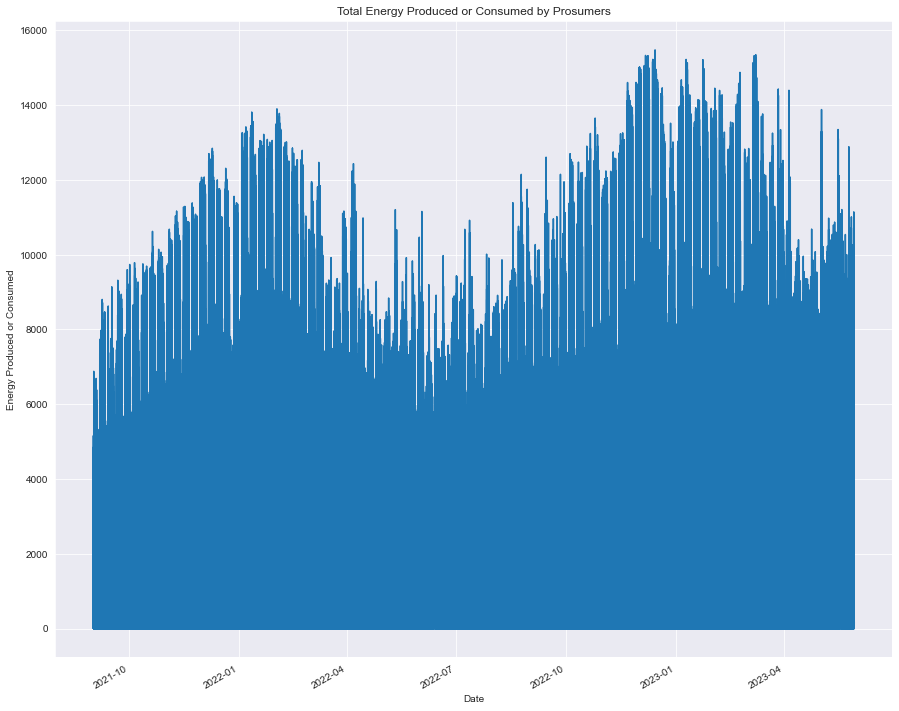

In [12]:
sns.set_style('darkgrid')

df['target'].plot(figsize = (15,13))
plt.title("Total Energy Produced or Consumed by Prosumers")
plt.xlabel("Date")
plt.ylabel("Energy Produced or Consumed")
plt.savefig("total_produced_consumed.png")
plt.show()

## Hourly Downsampled Data to Houly Sum

In [15]:
def downsampledHourly(df):
    downsampling_rules = {
        'is_business': 'last',
        'product_type': 'last',
        'is_consumption': 'last',
        'installed_capacity': 'sum',
        'eic_count': 'last',
        'forecasted_lowest_gas_price_per_mwh': 'mean',
        'forecasted_highest_gas_price_per_mwh': 'mean',
        'forecasted_electric_price_mwh': 'mean',
        'temperature': 'mean',
        'dewpoint': 'mean',
        'rain': 'mean',
        'snowfall': 'mean',
        'surface_pressure': 'mean',
        'cloudcover_total': 'mean',
        'cloudcover_low': 'mean',
        'cloudcover_mid': 'mean',
        'cloudcover_high': 'mean',
        'windspeed_10m': 'mean',
        'winddirection_10m': 'mean',
        'shortwave_radiation': 'mean',
        'direct_solar_radiation': 'mean',
        'diffuse_radiation': 'mean',
        'latitude': 'last',
        'longitude': 'last',
        'target': 'sum'
    }

    # Resample the DataFrame using the downsampling rules
    downsampled_df = df.resample('H').agg(downsampling_rules)
    downsampled_df = downsampled_df[['installed_capacity','eic_count', 'forecasted_lowest_gas_price_per_mwh', 'forecasted_highest_gas_price_per_mwh', 'forecasted_electric_price_mwh', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
           'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
           'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
           'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
           'latitude', 'longitude', 'target']]
    return downsampled_df

In [16]:
consumptionOnly_hourly = downsampledHourly(consumptionOnly)
productionOnly_hourly = downsampledHourly(productionOnly)

In [17]:
consumptionOnly_hourly.reset_index()['datetime'].min()

Timestamp('2021-09-01 00:00:00')

In [18]:
consumptionOnly_hourly.reset_index()['datetime'].max()

Timestamp('2023-05-29 23:00:00')

In [13]:
productionOnly_hourly.reset_index()['datetime'].min()

Timestamp('2021-09-01 00:00:00')

In [14]:
productionOnly_hourly.reset_index()['datetime'].max()

Timestamp('2023-05-29 23:00:00')

In [9]:
consumptionOnly_hourly.head(2)

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26        7.0   
2021-09-01 01:00:00            70659.26       37.0   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 01:00:00                                45.62   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 01:00:00                                 46.29   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 01:00:00                          94.77    13.211607  10.875893   

                         rain  snowfall  surface_pressure  ...  \
datetime                                                   ...   
2021-09-01 00:00:00  0.013393       0.0       1009.517857  ...   
2021-09-01 01:00:00  0.005357       0.0       1009.345536  ...   

                     cloudcover_mid  cloudcover_high  windspeed_10m  \
datetime                                                              
2021-09-01 00:00:00        5.062500        28.901786       5.114335   
2021-09-01 01:00:00        3.517857        29.089286       5.082341   

                     winddirection_10m  shortwave_radiation  \
datetime                                                      
2021-09-01 00:00:00         319.419643             6.312500   
2021-09-01 01:00:00         311.482143             3.892857   

                     direct_solar_radiation  diffuse_radiation  latitude  \
datetime                                                                   
2021-09-01 00:00:00                4.919643           1.392857     58.65   
2021-09-01 01:00:00                2.750000           1.142857     58.65   

                     longitude     target  
datetime                                   
2021-09-01 00:00:00      24.95  19859.808  
2021-09-01 01:00:00      24.95  19265.078  

[2 rows x 22 columns]

In [16]:
consumptionOnly_hourly.describe()['target']

count    15264.000000
mean     30366.083487
std       9960.217975
min          0.000000
25%      23725.398250
50%      28928.608500
75%      36060.478750
max      63354.178000
Name: target, dtype: float64

In [19]:
productionOnly_hourly.describe()['target']

count    15264.000000
mean      5800.851650
std      12352.418858
min          0.000000
25%         42.796750
50%        108.764500
75%       3806.695500
max      89930.586000
Name: target, dtype: float64

In [10]:
productionOnly_hourly.head(2)

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26       67.0   
2021-09-01 01:00:00            70659.26       31.0   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 01:00:00                                45.62   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 01:00:00                                 46.29   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 01:00:00                          94.77    13.211607  10.875893   

                         rain  snowfall  surface_pressure  ...  \
datetime                                                   ...   
2021-09-01 00:00:00  0.013393       0.0       1009.517857  ...   
2021-09-01 01:00:00  0.005357       0.0       1009.345536  ...   

                     cloudcover_mid  cloudcover_high  windspeed_10m  \
datetime                                                              
2021-09-01 00:00:00        5.062500        28.901786       5.114335   
2021-09-01 01:00:00        3.517857        29.089286       5.082341   

                     winddirection_10m  shortwave_radiation  \
datetime                                                      
2021-09-01 00:00:00         319.419643             6.312500   
2021-09-01 01:00:00         311.482143             3.892857   

                     direct_solar_radiation  diffuse_radiation  latitude  \
datetime                                                                   
2021-09-01 00:00:00                4.919643           1.392857     58.65   
2021-09-01 01:00:00                2.750000           1.142857     58.65   

                     longitude  target  
datetime                                
2021-09-01 00:00:00      24.95   4.362  
2021-09-01 01:00:00      24.95  11.852  

[2 rows x 22 columns]

In [ ]:
## Functions
# 1. Scatterplot for correlation check.
# 2. Datetime features creators
# 3. Lags creator
# 4. PACF
# 5. ACF

# Exploring Production Only

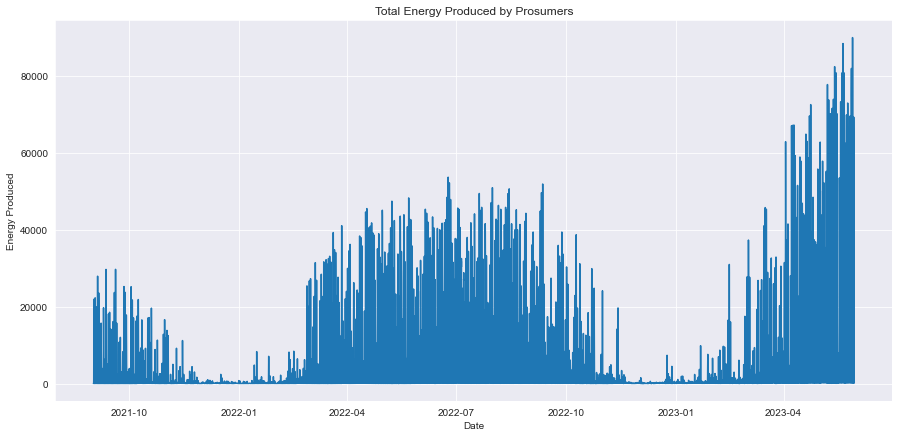

In [22]:
plt.figure(figsize=(15,7))
sns.lineplot(x=productionOnly_hourly.index, y= 'target', data = productionOnly_hourly)
plt.title('Total Energy Produced by Prosumers')
plt.xlabel("Date")
plt.ylabel("Energy Produced")
plt.savefig("energy_produced.png")
plt.show()

## Feature correlation with target

In [61]:
def correlationPlot(data, x, y):
    plt.figure(figsize = (12,8))
    sns.scatterplot(x = x, y = y,alpha =0.6, data = data).set(title = 'Correlation between ' + str(x).capitalize() + ' and the ' + str(y).capitalize())
    plt.xlabel(x)
    

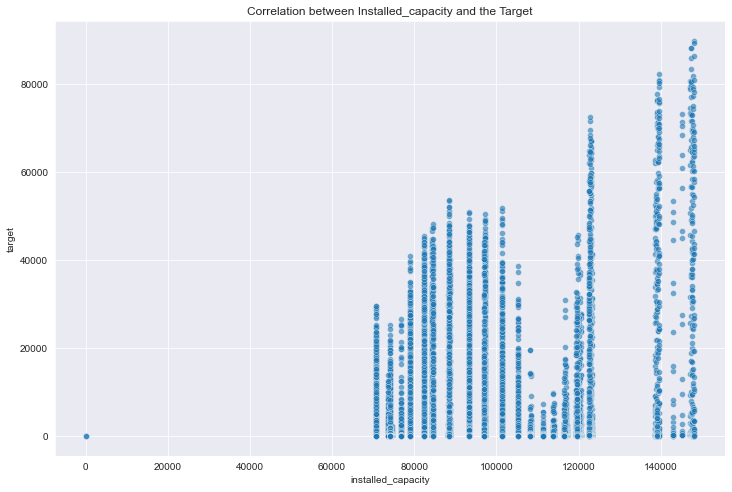

In [62]:
correlationPlot(productionOnly_hourly,'installed_capacity', 'target')

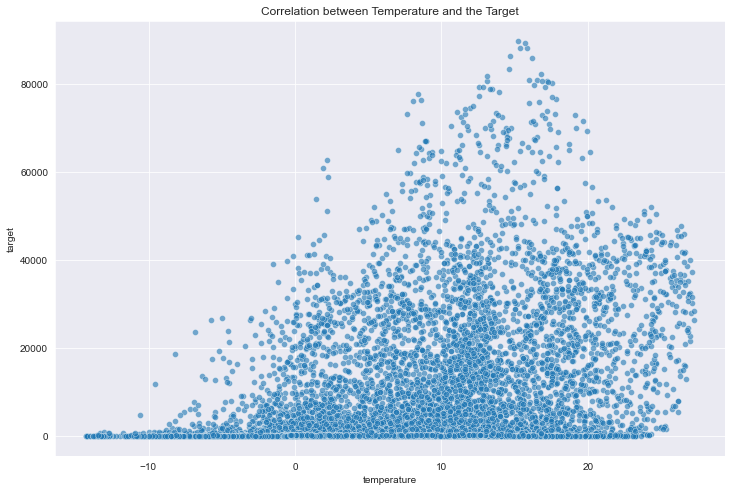

In [55]:
correlationPlot(productionOnly_hourly,'temperature', 'target')

In [ ]:
# There is an positive relationship between energy produced and temperature

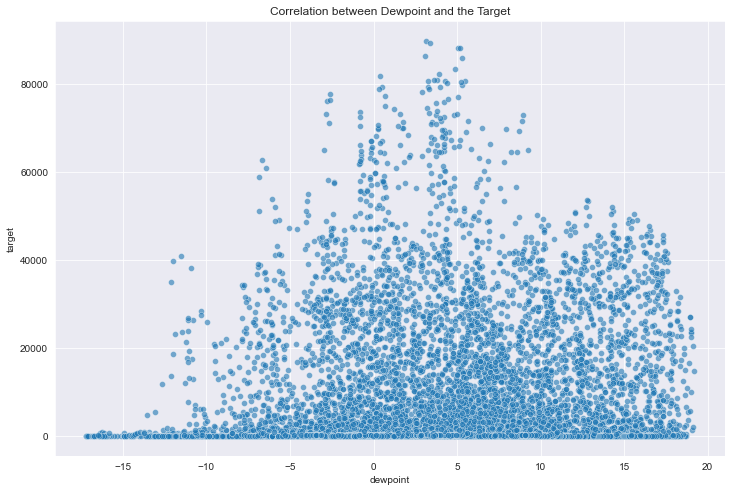

In [56]:
correlationPlot(productionOnly_hourly,'dewpoint', 'target')

In [ ]:
# There is an positive relationship between energy produced and dewpoint

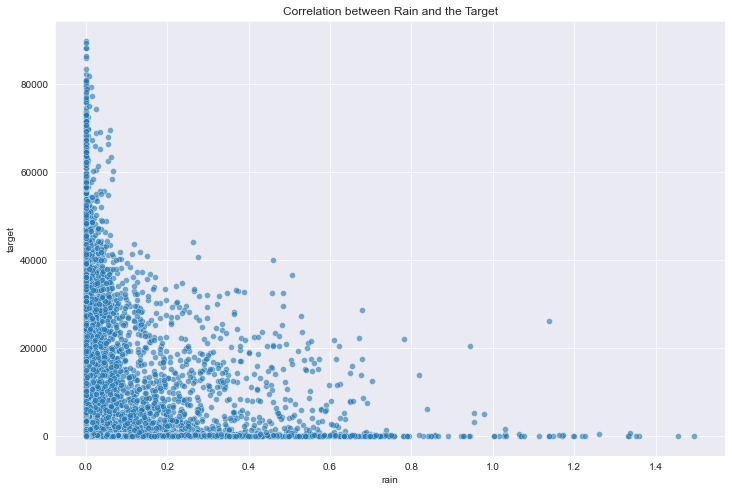

In [57]:
correlationPlot(productionOnly_hourly,'rain', 'target')

In [ ]:
# The appears to be a negative relationship between rainfall and energy produced

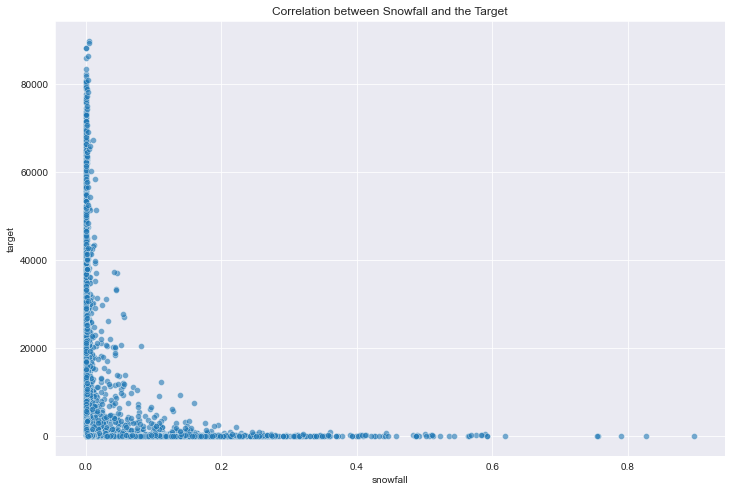

In [58]:
correlationPlot(productionOnly_hourly,'snowfall', 'target')

In [ ]:
# Inverse relationship between energy produced and snow fall

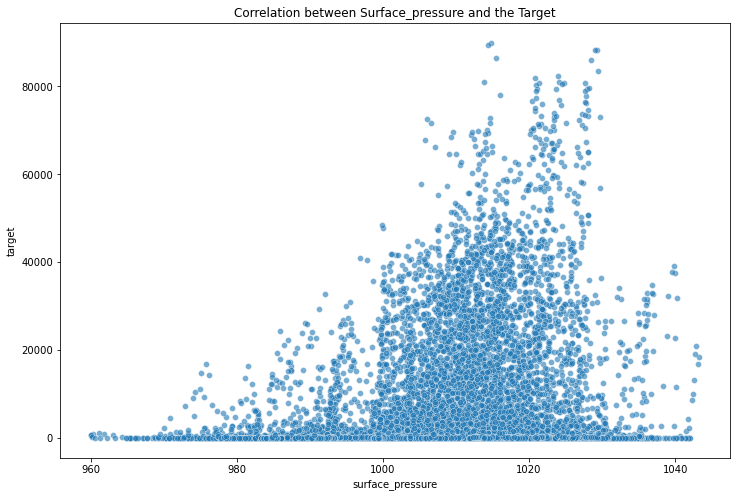

In [39]:
correlationPlot(productionOnly_hourly,'surface_pressure', 'target')

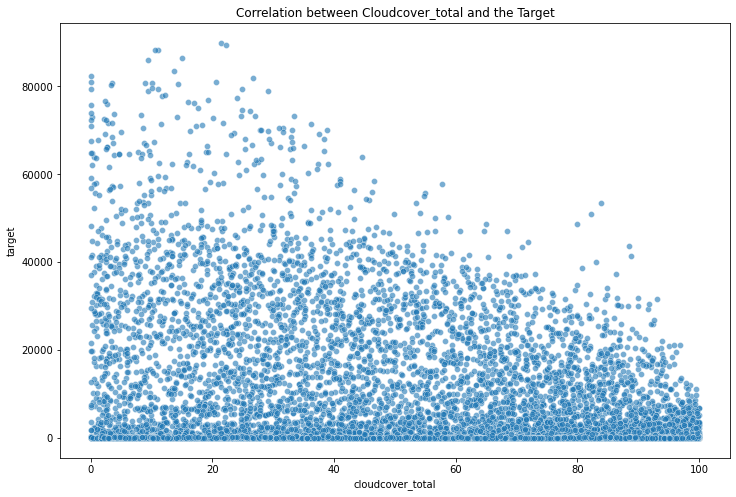

In [40]:
correlationPlot(productionOnly_hourly,'cloudcover_total', 'target')

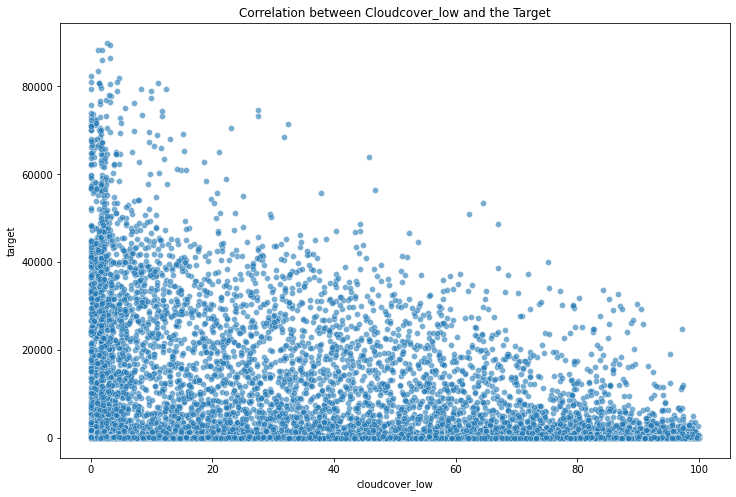

In [41]:
correlationPlot(productionOnly_hourly,'cloudcover_low', 'target')

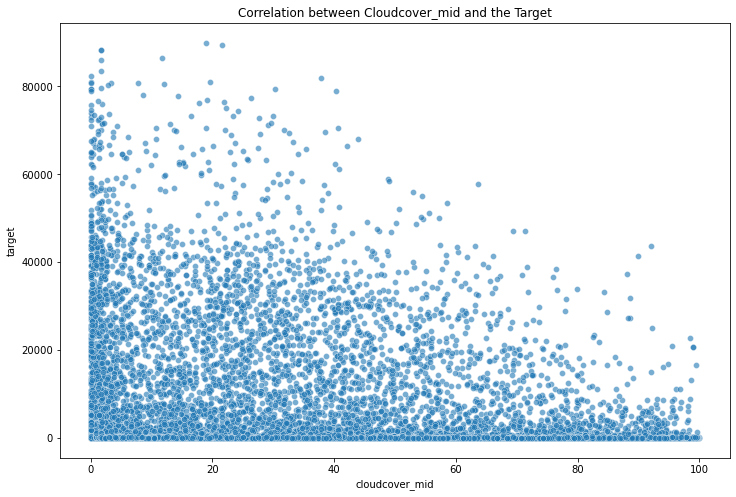

In [42]:
correlationPlot(productionOnly_hourly,'cloudcover_mid', 'target')

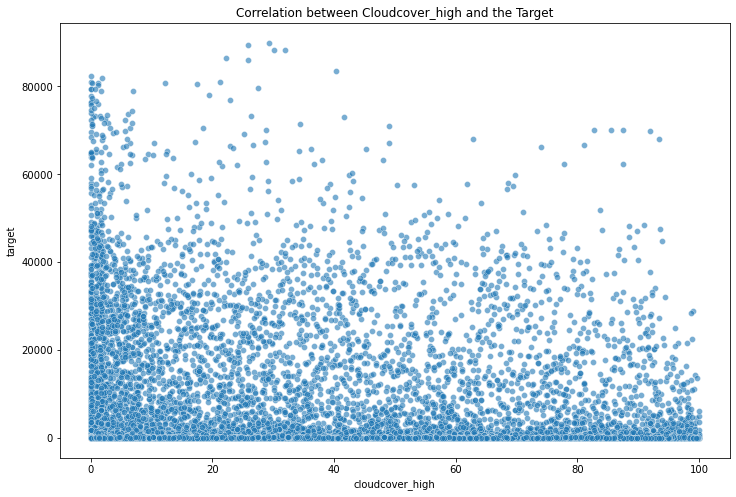

In [43]:
correlationPlot(productionOnly_hourly,'cloudcover_high', 'target')

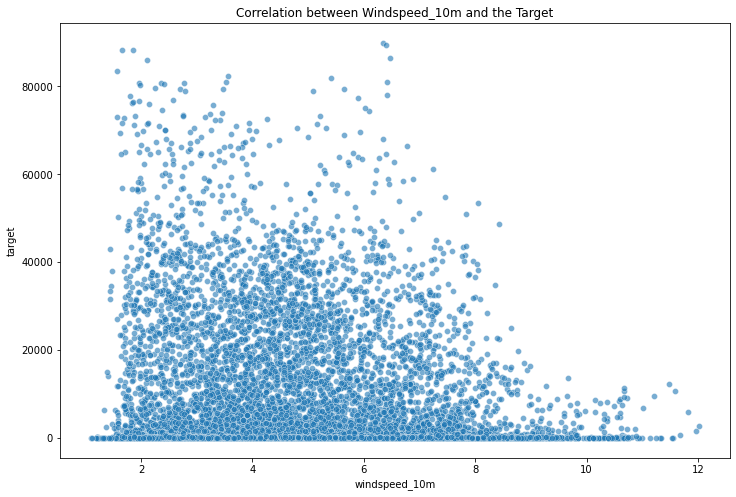

In [44]:
correlationPlot(productionOnly_hourly,'windspeed_10m', 'target')

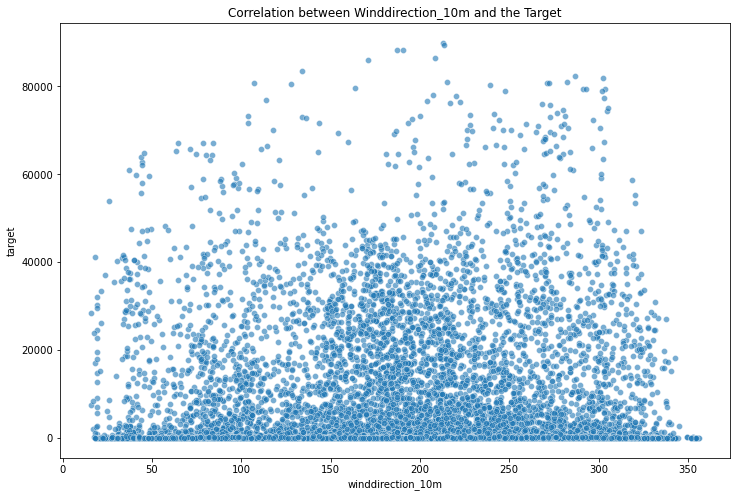

In [45]:
correlationPlot(productionOnly_hourly,'winddirection_10m', 'target')

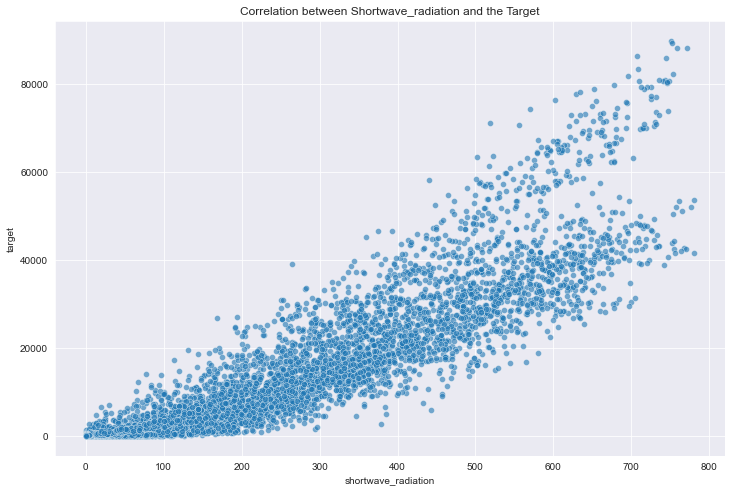

In [59]:
correlationPlot(productionOnly_hourly,'shortwave_radiation', 'target')

In [ ]:
# There is a strong relationship between shortwave radiation and energy produced

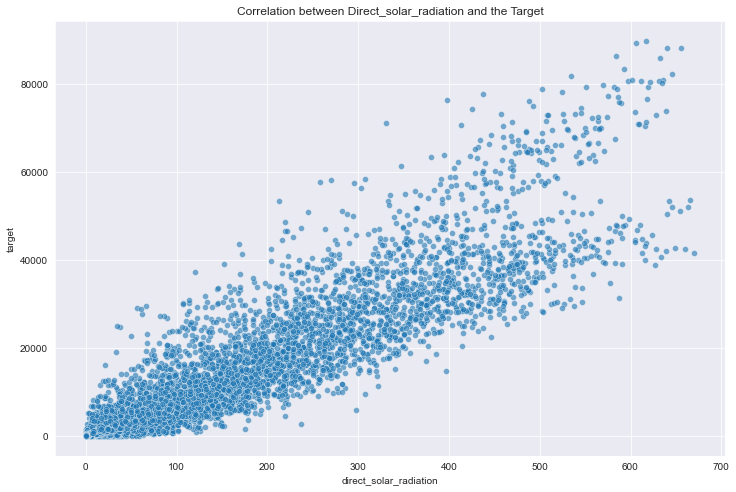

In [60]:
correlationPlot(productionOnly_hourly,'direct_solar_radiation', 'target')

In [ ]:
# There is a positive relationship between direct_solar radiation and energy produced

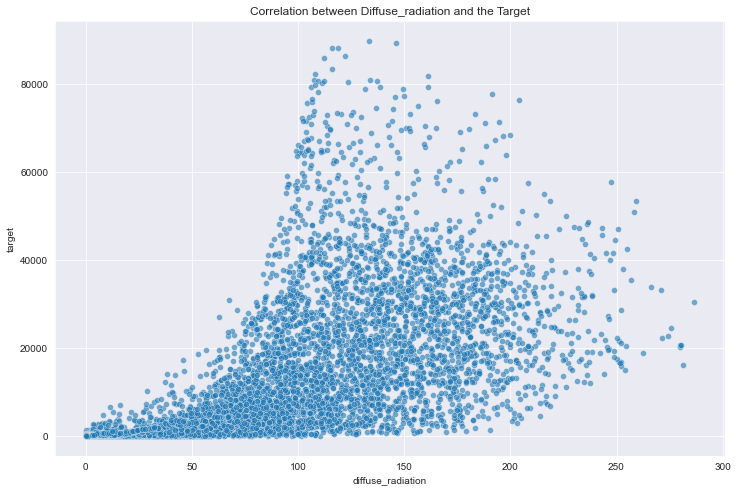

In [63]:
correlationPlot(productionOnly_hourly,'diffuse_radiation', 'target')

In [ ]:
# There is a positive relationship between direct_solar radiation and energy produced

### Extracting More Weather Features

In [64]:
productionOnly_hourly['total_radiation'] = productionOnly_hourly['direct_solar_radiation'] + productionOnly_hourly['diffuse_radiation']
productionOnly_hourly['solar_radiation_ratio'] = productionOnly_hourly['direct_solar_radiation']/productionOnly_hourly['diffuse_radiation']
productionOnly_hourly['solar_radiation_product'] = productionOnly_hourly['direct_solar_radiation']*productionOnly_hourly['diffuse_radiation']

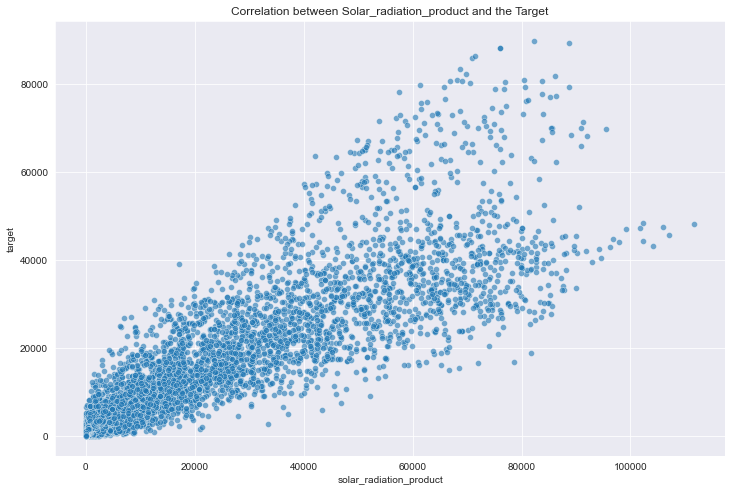

In [65]:
correlationPlot(productionOnly_hourly,'solar_radiation_product', 'target')

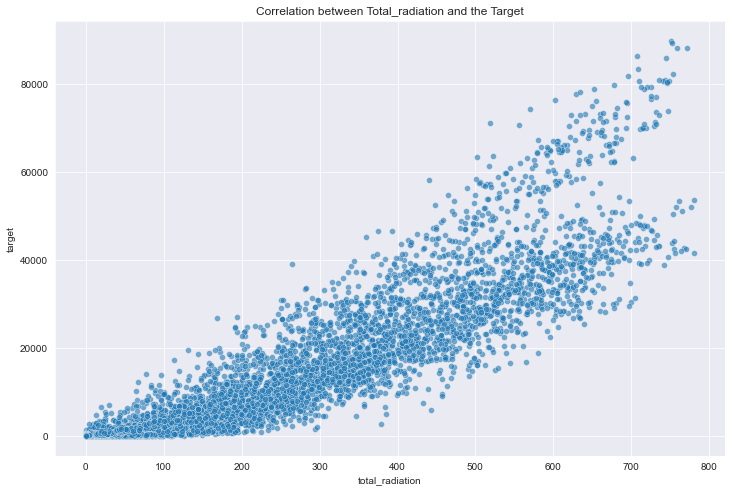

In [66]:
correlationPlot(productionOnly_hourly,'total_radiation', 'target')

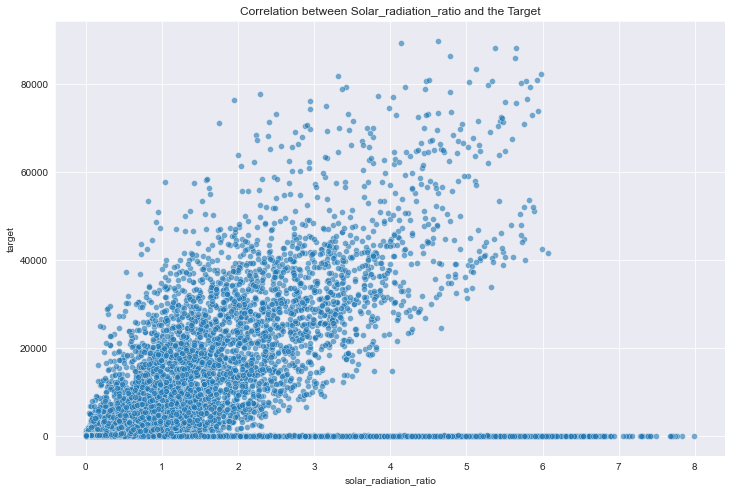

In [67]:
correlationPlot(productionOnly_hourly,'solar_radiation_ratio', 'target')

### Extracting more features

In [69]:
productionOnly_hourly['installed_capacity_total_solar'] = productionOnly_hourly['solar_radiation_product']*productionOnly_hourly['installed_capacity']

In [262]:
df_hourly.columns

Index(['installed_capacity', 'eic_count',
       'forecasted_lowest_gas_price_per_mwh',
       'forecasted_highest_gas_price_per_mwh', 'forecasted_electric_price_mwh',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'latitude', 'longitude', 'target', 'total_radiation',
       'solar_radiation_ratio', 'solar_radiation_product',
       'installed_capacity_total_solar'],
      dtype='object')

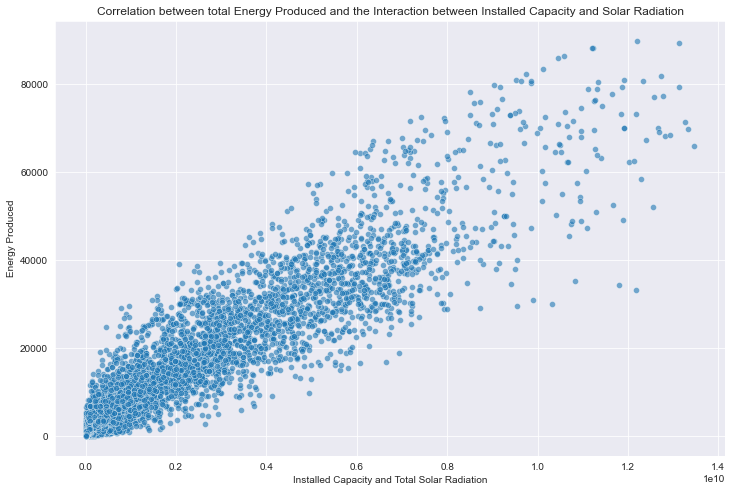

In [87]:
correlationPlot(productionOnly_hourly,'installed_capacity_total_solar', 'target')
plt.xlabel("Installed Capacity and Total Solar Radiation")
plt.title("Correlation between total Energy Produced and the Interaction between Installed Capacity and Solar Radiation")
plt.ylabel("Energy Produced")
plt.savefig("totalcapacitysolar.png")

In [58]:
productionOnly_hourly['temperature_dewpoint'] = productionOnly_hourly['temperature'] + productionOnly_hourly['dewpoint']

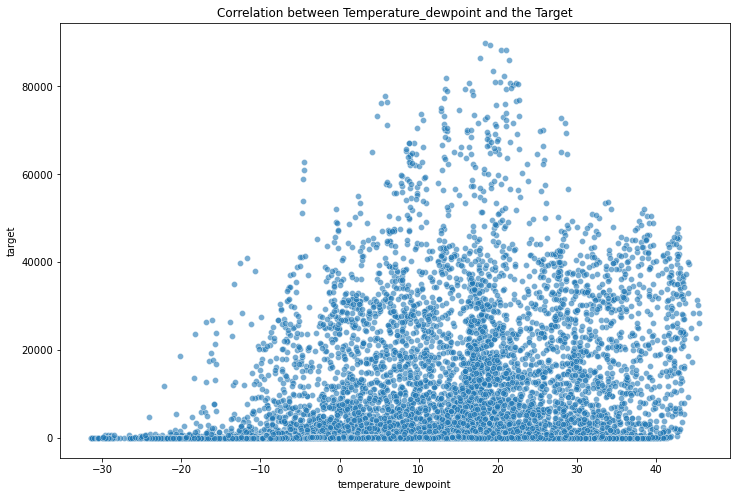

In [59]:
correlationPlot(productionOnly_hourly,'temperature_dewpoint', 'target')

### Extracting Lag Features

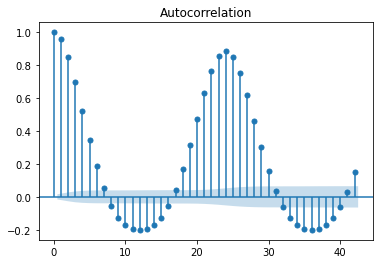

In [60]:
plot_acf(productionOnly_hourly['target'],)
plt.show()

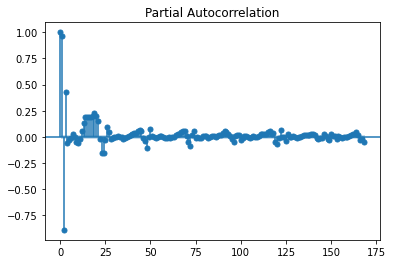

In [61]:
plot_pacf(productionOnly_hourly['target'],lags =168)
plt.show()

#### Lag1(Hour before) lag24(Day before) lag168 (Week before)

In [80]:
## Function to create lag
def createLag(dataframe, lag):
    dataframe['lag_' + str(lag)] = dataframe['target'].shift(lag, freq = 'H')   

In [82]:
lags = [1,2,24,168]
for lag in lags:
    createLag(productionOnly_hourly, lag)

In [64]:
productionOnly_hourly.head()

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26       67.0   
2021-09-01 01:00:00            70659.26       31.0   
2021-09-01 02:00:00            70659.26       67.0   
2021-09-01 03:00:00            70659.26        8.0   
2021-09-01 04:00:00            70659.26       61.0   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 01:00:00                                45.62   
2021-09-01 02:00:00                                45.62   
2021-09-01 03:00:00                                45.62   
2021-09-01 04:00:00                                45.62   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 01:00:00                                 46.29   
2021-09-01 02:00:00                                 46.29   
2021-09-01 03:00:00                                 46.29   
2021-09-01 04:00:00                                 46.29   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 01:00:00                          94.77    13.211607  10.875893   
2021-09-01 02:00:00                          93.88    13.109821  10.759821   
2021-09-01 03:00:00                          92.25    12.985714  10.575893   
2021-09-01 04:00:00                          91.83    12.863393  10.410714   

                         rain  snowfall  surface_pressure  ...  target  \
datetime                                                   ...           
2021-09-01 00:00:00  0.013393       0.0       1009.517857  ...   4.362   
2021-09-01 01:00:00  0.005357       0.0       1009.345536  ...  11.852   
2021-09-01 02:00:00  0.001786       0.0       1008.944643  ...   1.845   
2021-09-01 03:00:00  0.000000       0.0       1008.779464  ...   1.517   
2021-09-01 04:00:00  0.000000       0.0       1008.670536  ...   2.492   

                     total_radiation  solar_radiation_ratio  \
datetime                                                      
2021-09-01 00:00:00         6.312500               3.532051   
2021-09-01 01:00:00         3.892857               2.406250   
2021-09-01 02:00:00         1.758929               1.317647   
2021-09-01 03:00:00         0.330357               0.541667   
2021-09-01 04:00:00         0.000000                    NaN   

                     solar_radiation_product  installed_capacity_total_solar  \
datetime                                                                       
2021-09-01 00:00:00                 6.852360                   484182.665223   
2021-09-01 01:00:00                 3.142857                   222071.960000   
2021-09-01 02:00:00                 0.758929                    53625.331250   
2021-09-01 03:00:00                 0.024872                     1757.468839   
2021-09-01 04:00:00                 0.000000                        0.000000   

                     temperature_dewpoint   lag_1   lag_2  lag_24  lag_168  
datetime                                                                    
2021-09-01 00:00:00             24.296429     NaN     NaN     NaN      NaN  
2021-09-01 01:00:00             24.087500   4.362     NaN     NaN      NaN  
2021-09-01 02:00:00             23.869643  11.852   4.362     NaN      NaN  
2021-09-01 03:00:00             23.561607   1.845  11.852     NaN      NaN  
2021-09-01 04:00:00             23.274107   1.517   1.845     NaN      NaN  

[5 rows x 31 columns]

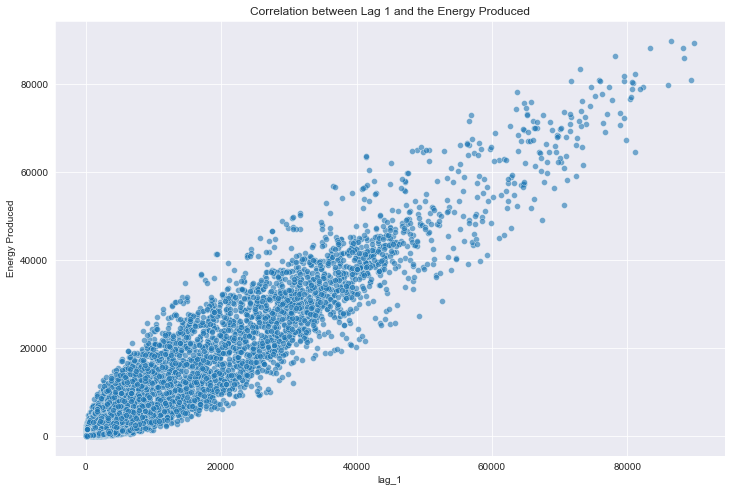

In [86]:
correlationPlot(productionOnly_hourly,'lag_1', 'target')
plt.ylabel("Energy Produced")
plt.title("Correlation between Lag 1 and the Energy Produced")
plt.savefig("lag1eproduced.png")

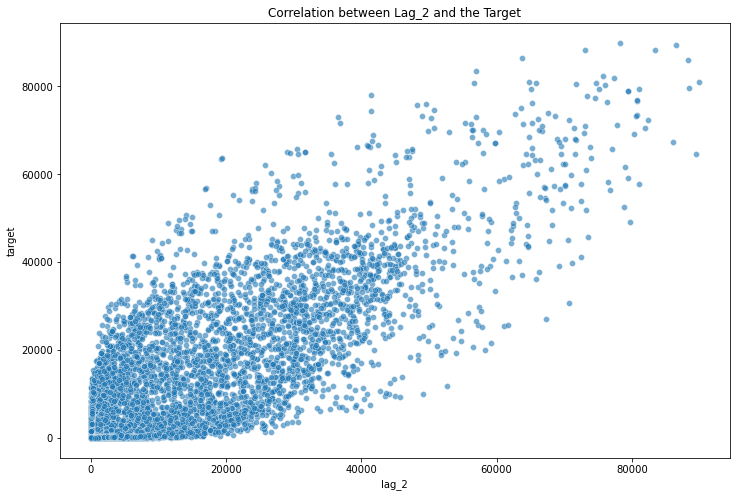

In [66]:
correlationPlot(productionOnly_hourly,'lag_2', 'target')

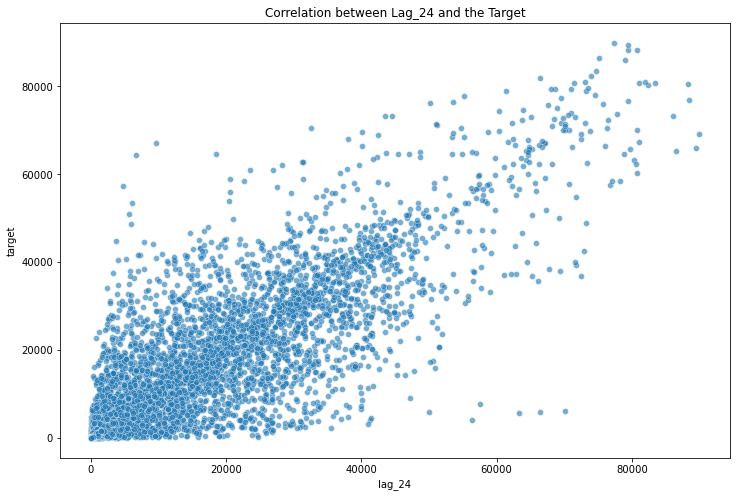

In [67]:
correlationPlot(productionOnly_hourly,'lag_24', 'target')

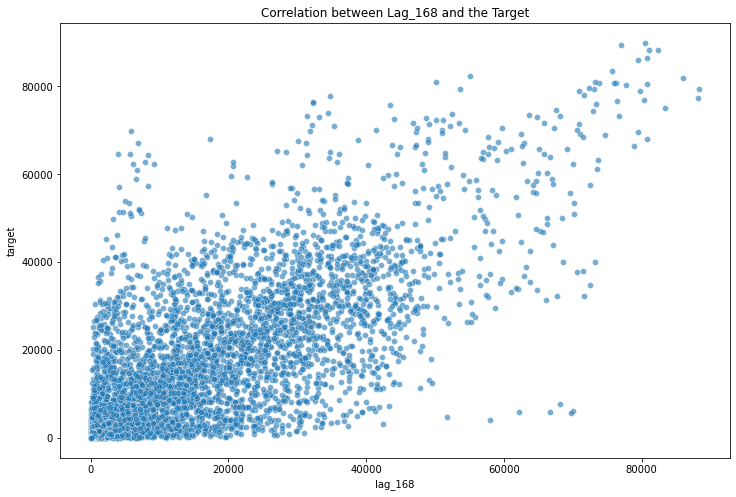

In [68]:
correlationPlot(productionOnly_hourly,'lag_168', 'target')

## Extracting Date time features using Feature Engine


In [29]:
dtf = DatetimeFeatures(
    variables = None,
    features_to_extract = ['hour','month', 'year', 'day_of_week', 'weekend'],
    drop_original = False)

In [30]:
productionOnly_hourly = dtf.fit_transform(productionOnly_hourly.reset_index())
productionOnly_hourly.set_index('datetime', inplace = True)

In [32]:
def cyclicalFeature(datetime):
    productionOnly_hourly[str(datetime)+"_cosine"] = np.cos(productionOnly_hourly[datetime] /
                              productionOnly_hourly[datetime].max() * 2 * np.pi)
    productionOnly_hourly[str(datetime)+"_sin"] = np.sin(productionOnly_hourly[datetime] /
                              productionOnly_hourly[datetime].max() * 2 * np.pi)
     

In [33]:
periods = ['datetime_hour', 'datetime_month', 'datetime_day_of_week']
for datetime in periods:
    cyclicalFeature(datetime)

In [34]:
productionOnly_hourly.head()

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26       67.0   
2021-09-01 01:00:00            70659.26       31.0   
2021-09-01 02:00:00            70659.26       67.0   
2021-09-01 03:00:00            70659.26        8.0   
2021-09-01 04:00:00            70659.26       61.0   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 01:00:00                                45.62   
2021-09-01 02:00:00                                45.62   
2021-09-01 03:00:00                                45.62   
2021-09-01 04:00:00                                45.62   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 01:00:00                                 46.29   
2021-09-01 02:00:00                                 46.29   
2021-09-01 03:00:00                                 46.29   
2021-09-01 04:00:00                                 46.29   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 01:00:00                          94.77    13.211607  10.875893   
2021-09-01 02:00:00                          93.88    13.109821  10.759821   
2021-09-01 03:00:00                          92.25    12.985714  10.575893   
2021-09-01 04:00:00                          91.83    12.863393  10.410714   

                         rain  snowfall  surface_pressure  ...  \
datetime                                                   ...   
2021-09-01 00:00:00  0.013393       0.0       1009.517857  ...   
2021-09-01 01:00:00  0.005357       0.0       1009.345536  ...   
2021-09-01 02:00:00  0.001786       0.0       1008.944643  ...   
2021-09-01 03:00:00  0.000000       0.0       1008.779464  ...   
2021-09-01 04:00:00  0.000000       0.0       1008.670536  ...   

                     datetime_month  datetime_year  datetime_day_of_week  \
datetime                                                                   
2021-09-01 00:00:00               9           2021                     2   
2021-09-01 01:00:00               9           2021                     2   
2021-09-01 02:00:00               9           2021                     2   
2021-09-01 03:00:00               9           2021                     2   
2021-09-01 04:00:00               9           2021                     2   

                     datetime_weekend  datetime_hour_cosine  \
datetime                                                      
2021-09-01 00:00:00                 0              1.000000   
2021-09-01 01:00:00                 0              0.962917   
2021-09-01 02:00:00                 0              0.854419   
2021-09-01 03:00:00                 0              0.682553   
2021-09-01 04:00:00                 0              0.460065   

                     datetime_hour_sin  datetime_month_cosine  \
datetime                                                        
2021-09-01 00:00:00           0.000000          -1.836970e-16   
2021-09-01 01:00:00           0.269797          -1.836970e-16   
2021-09-01 02:00:00           0.519584          -1.836970e-16   
2021-09-01 03:00:00           0.730836          -1.836970e-16   
2021-09-01 04:00:00           0.887885          -1.836970e-16   

                     datetime_month_sin  datetime_day_of_week_cosine  \
datetime                                                               
2021-09-01 00:00:00                -1.0                         -0.5   
2021-09-01 01:00:00                -1.0                         -0.5   
2021-09-01 02:00:00                -1.0                         

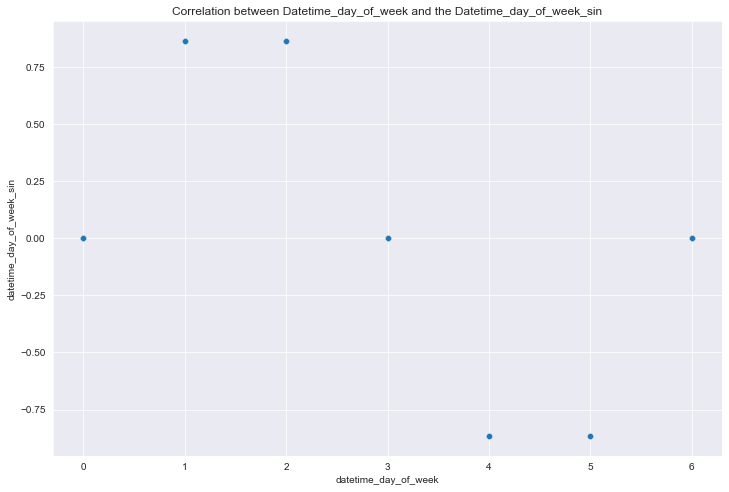

In [35]:
correlationPlot(productionOnly_hourly,'datetime_day_of_week', 'datetime_day_of_week_sin')

In [46]:
def plotDatetimeAverage(datetime):
    productionOnly_hourly.groupby(datetime)['target'].mean().plot(figsize = (18,10))
    plt.title('Average Energy Produced in ' + "Per " + str(datetime)[9:])

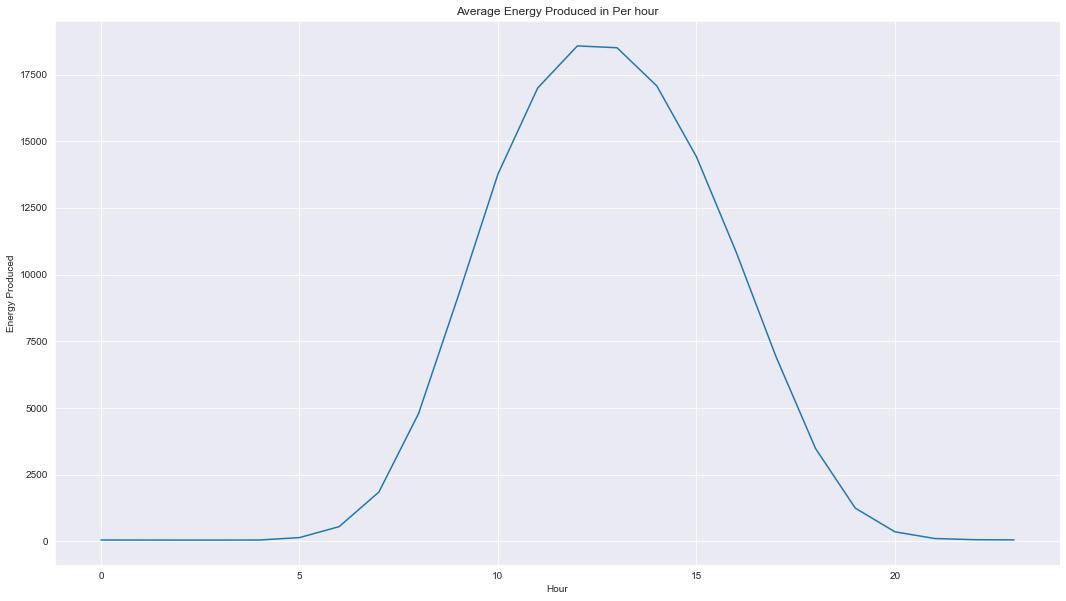

In [49]:
plotDatetimeAverage('datetime_hour')
plt.xlabel('Hour')
plt.ylabel('Energy Produced')
plt.savefig("energy_produced_perhour.png")

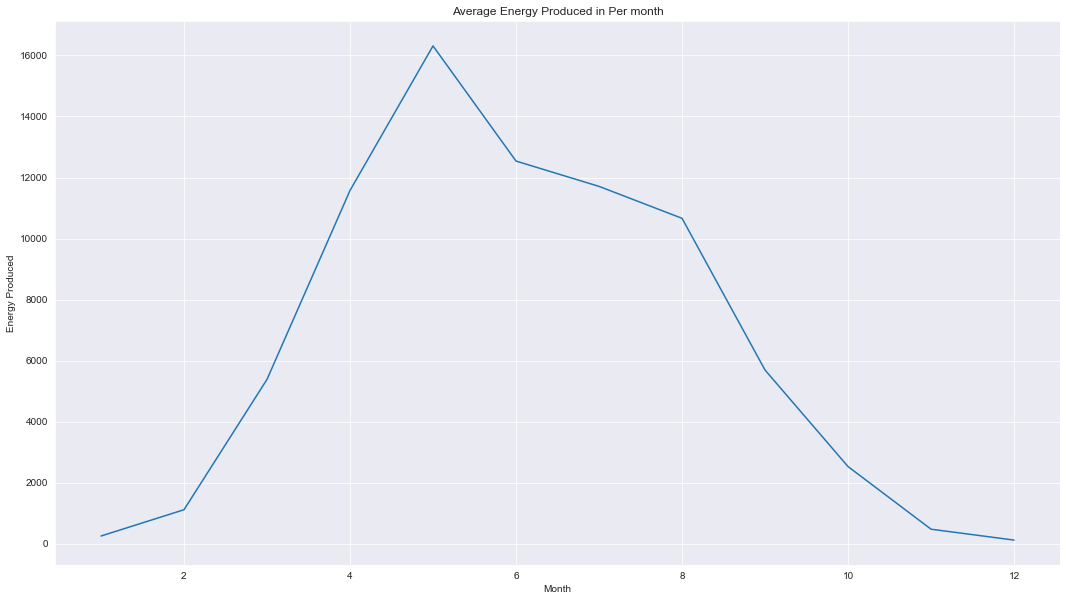

In [50]:
plotDatetimeAverage('datetime_month')
plt.xlabel('Month')
plt.ylabel('Energy Produced')
plt.savefig("energy_produced_permonth.png")

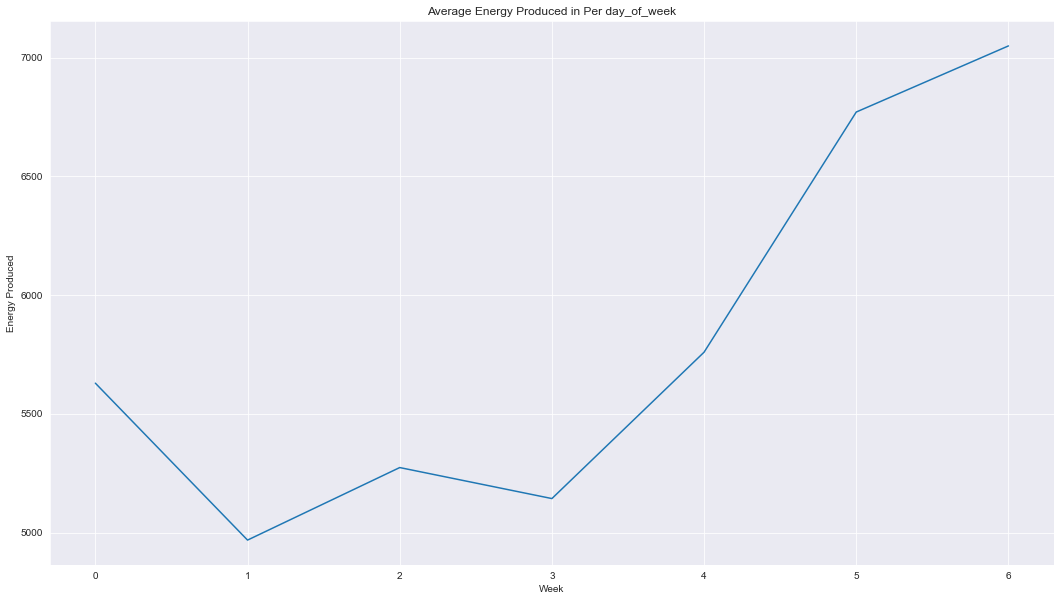

In [51]:
plotDatetimeAverage('datetime_day_of_week')
plt.xlabel('Week')
plt.ylabel('Energy Produced')
plt.savefig("energy_produced_perweek.png")

In [85]:
# Creating Seasonal Features
def get_season(month):
    if 1 <= month <= 3:
        return 'early_year'
    elif 4 <= month <= 7:
        return 'early_mid'
    elif 8 <= month <= 10:
        return 'late_mid'
    else:
        return 'late_year'
productionOnly_hourly['time_in_year'] = productionOnly_hourly['datetime_month'].apply(get_season)


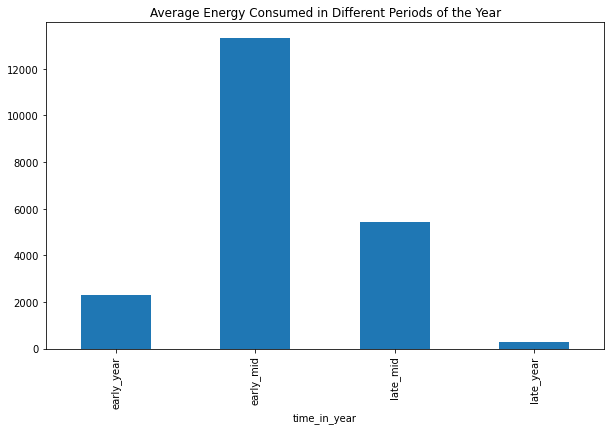

In [86]:
grouped_data = productionOnly_hourly.groupby('time_in_year')['target'].mean()
custom_order = ['early_year', 'early_mid', 'late_mid', 'late_year']
grouped_data = grouped_data.reindex(custom_order)
# Create bar plot with custom order
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Average Energy Consumed in Different Periods of the Year')
plt.show()

## Window features

In [87]:
#window_size = [24,168]

productionOnly_hourly['window_24'] = (productionOnly_hourly['target'].rolling(window =24, min_periods = 1)).mean().shift(1)
productionOnly_hourly['window_168'] = (productionOnly_hourly['target'].rolling(window =168, min_periods = 1)).mean().shift(1)

In [88]:
productionOnly_hourly.head()

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26       67.0   
2021-09-01 01:00:00            70659.26       31.0   
2021-09-01 02:00:00            70659.26       67.0   
2021-09-01 03:00:00            70659.26        8.0   
2021-09-01 04:00:00            70659.26       61.0   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 01:00:00                                45.62   
2021-09-01 02:00:00                                45.62   
2021-09-01 03:00:00                                45.62   
2021-09-01 04:00:00                                45.62   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 01:00:00                                 46.29   
2021-09-01 02:00:00                                 46.29   
2021-09-01 03:00:00                                 46.29   
2021-09-01 04:00:00                                 46.29   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 01:00:00                          94.77    13.211607  10.875893   
2021-09-01 02:00:00                          93.88    13.109821  10.759821   
2021-09-01 03:00:00                          92.25    12.985714  10.575893   
2021-09-01 04:00:00                          91.83    12.863393  10.410714   

                         rain  snowfall  surface_pressure  ...  \
datetime                                                   ...   
2021-09-01 00:00:00  0.013393       0.0       1009.517857  ...   
2021-09-01 01:00:00  0.005357       0.0       1009.345536  ...   
2021-09-01 02:00:00  0.001786       0.0       1008.944643  ...   
2021-09-01 03:00:00  0.000000       0.0       1008.779464  ...   
2021-09-01 04:00:00  0.000000       0.0       1008.670536  ...   

                     datetime_weekend  datetime_hour_cosine  \
datetime                                                      
2021-09-01 00:00:00                 0              1.000000   
2021-09-01 01:00:00                 0              0.962917   
2021-09-01 02:00:00                 0              0.854419   
2021-09-01 03:00:00                 0              0.682553   
2021-09-01 04:00:00                 0              0.460065   

                     datetime_hour_sin  datetime_month_cosine  \
datetime                                                        
2021-09-01 00:00:00           0.000000          -1.836970e-16   
2021-09-01 01:00:00           0.269797          -1.836970e-16   
2021-09-01 02:00:00           0.519584          -1.836970e-16   
2021-09-01 03:00:00           0.730836          -1.836970e-16   
2021-09-01 04:00:00           0.887885          -1.836970e-16   

                     datetime_month_sin  datetime_day_of_week_cosine  \
datetime                                                               
2021-09-01 00:00:00                -1.0                         -0.5   
2021-09-01 01:00:00                -1.0                         -0.5   
2021-09-01 02:00:00                -1.0                         -0.5   
2021-09-01 03:00:00                -1.0                         -0.5   
2021-09-01 04:00:00                -1.0                         -0.5   

                     datetime_day_of_week_sin  time_in_year  window_24  \
datetime                                                                 
2021-09-01 00:00:00                  0.866025      late_mid        NaN   
2021-09-01 01:00:00                  0.866025      late_mid   4.362000   
2021-09-01 02:00:00                  0.866025      late_mid   8.107000   
2021-09-01

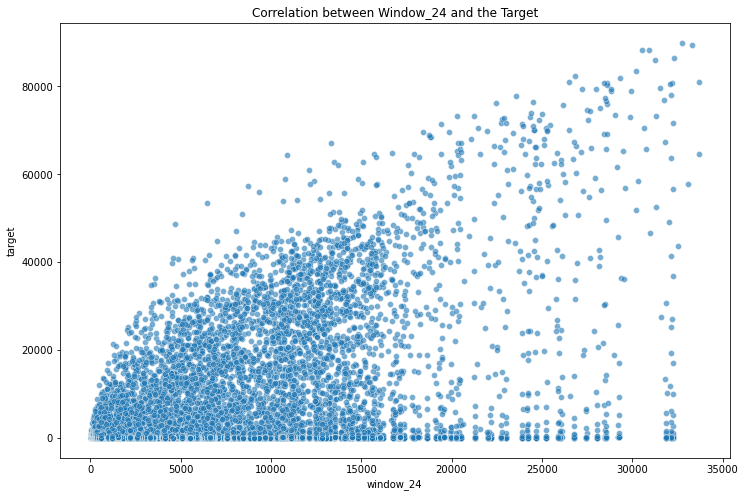

In [89]:
correlationPlot(productionOnly_hourly,'window_24', 'target')

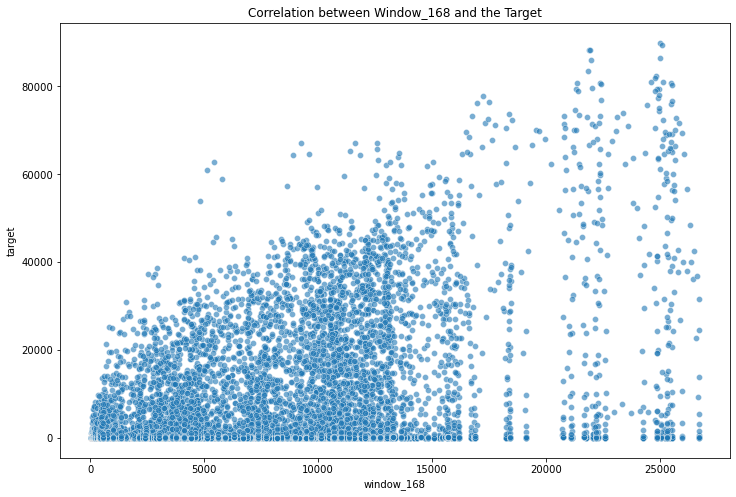

In [90]:
correlationPlot(productionOnly_hourly,'window_168', 'target')

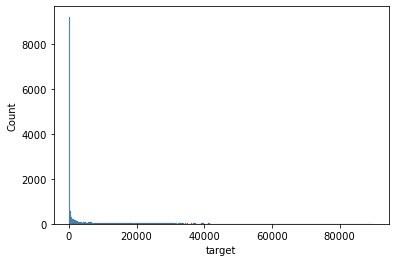

In [91]:
sns.histplot(productionOnly_hourly['target'])
plt.show()

C:\Users\Dell\New folder\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


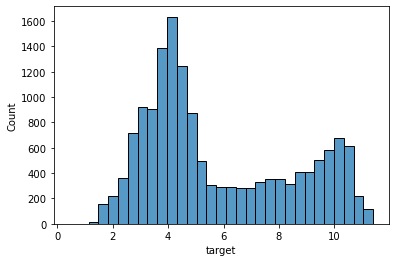

In [92]:
sns.histplot(np.log(productionOnly_hourly['target']))
plt.show()

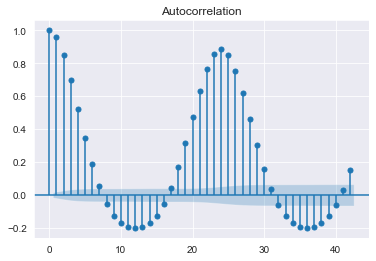

In [72]:
plot_acf(productionOnly_hourly['target'],)
plt.show()

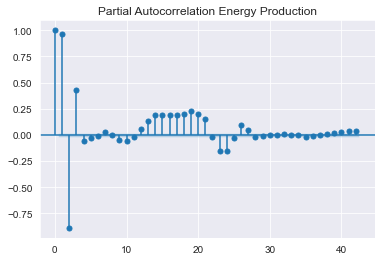

In [78]:
plot_pacf(productionOnly_hourly['target'],)
plt.title("Partial Autocorrelation Energy Production")
plt.savefig("partialautoproduced.png")
plt.show()


In [93]:
## finding average of forcasted gas price

productionOnly_hourly['forecasted_average_gas_price_per_mwh'] = (productionOnly_hourly['forecasted_lowest_gas_price_per_mwh'] + productionOnly_hourly['forecasted_electric_price_mwh'])/2

In [94]:
productionOnly_hourly.drop(columns = ['forecasted_lowest_gas_price_per_mwh', 'forecasted_electric_price_mwh'], axis = 1, inplace = True)

In [95]:
productionOnly_hourly.head()

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00            70659.26       67.0   
2021-09-01 01:00:00            70659.26       31.0   
2021-09-01 02:00:00            70659.26       67.0   
2021-09-01 03:00:00            70659.26        8.0   
2021-09-01 04:00:00            70659.26       61.0   

                     forecasted_highest_gas_price_per_mwh  temperature  \
datetime                                                                 
2021-09-01 00:00:00                                 46.29    13.308929   
2021-09-01 01:00:00                                 46.29    13.211607   
2021-09-01 02:00:00                                 46.29    13.109821   
2021-09-01 03:00:00                                 46.29    12.985714   
2021-09-01 04:00:00                                 46.29    12.863393   

                      dewpoint      rain  snowfall  surface_pressure  \
datetime                                                               
2021-09-01 00:00:00  10.987500  0.013393       0.0       1009.517857   
2021-09-01 01:00:00  10.875893  0.005357       0.0       1009.345536   
2021-09-01 02:00:00  10.759821  0.001786       0.0       1008.944643   
2021-09-01 03:00:00  10.575893  0.000000       0.0       1008.779464   
2021-09-01 04:00:00  10.410714  0.000000       0.0       1008.670536   

                     cloudcover_total  cloudcover_low  ...  \
datetime                                               ...   
2021-09-01 00:00:00         48.294643       43.357143  ...   
2021-09-01 01:00:00         42.803571       36.901786  ...   
2021-09-01 02:00:00         35.312500       31.196429  ...   
2021-09-01 03:00:00         33.491071       29.732143  ...   
2021-09-01 04:00:00         29.973214       26.767857  ...   

                     datetime_hour_cosine  datetime_hour_sin  \
datetime                                                       
2021-09-01 00:00:00              1.000000           0.000000   
2021-09-01 01:00:00              0.962917           0.269797   
2021-09-01 02:00:00              0.854419           0.519584   
2021-09-01 03:00:00              0.682553           0.730836   
2021-09-01 04:00:00              0.460065           0.887885   

                     datetime_month_cosine  datetime_month_sin  \
datetime                                                         
2021-09-01 00:00:00          -1.836970e-16                -1.0   
2021-09-01 01:00:00          -1.836970e-16                -1.0   
2021-09-01 02:00:00          -1.836970e-16                -1.0   
2021-09-01 03:00:00          -1.836970e-16                -1.0   
2021-09-01 04:00:00          -1.836970e-16                -1.0   

                     datetime_day_of_week_cosine  datetime_day_of_week_sin  \
datetime                                                                     
2021-09-01 00:00:00                         -0.5                  0.866025   
2021-09-01 01:00:00                         -0.5                  0.866025   
2021-09-01 02:00:00                         -0.5                  0.866025   
2021-09-01 03:00:00                         -0.5                  0.866025   
2021-09-01 04:00:00                         -0.5                  0.866025   

                     time_in_year  window_24  window_168  \
datetime                                                   
2021-09-01 00:00:00      late_mid        NaN         NaN   
2021-09-01 01:00:00      late_mid   4.362000    4.362000   
2021-09-01 02:00:00      late_mid   8.107000    8.107000   
2021-09-01 03:00:00      late_mid   6.019667    6.019667   
2021-09-01 04:00:00      late_mid   4.894000    4.894000   

                     forecasted_average_gas_price_per_mwh  
datetime                                                   
2021-09-01 00:00:00                                71.305  
2021-09-01 01:00:00                                70.195  
2021-09-01 02:00:00                                69.750  
202

In [96]:
productionOnly_hourly.to_csv('productionOnly_features.csv', index=True)


# Exploring Consumption Only

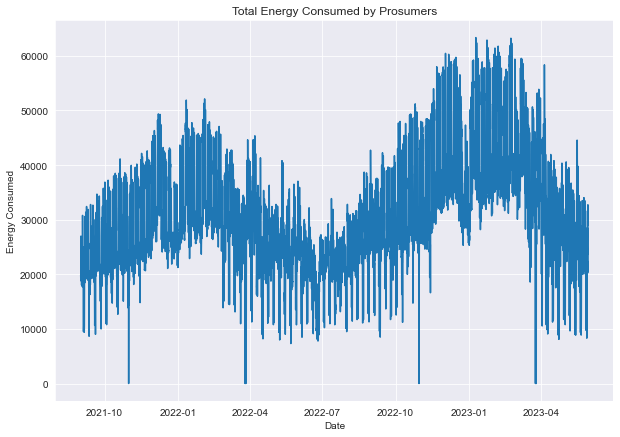

In [24]:
plt.figure(figsize=(10,7))
sns.lineplot(x=consumptionOnly_hourly.index, y= 'target', data = consumptionOnly_hourly)
plt.title('Total Energy Consumed by Prosumers')
plt.ylabel("Energy Consumed")
plt.xlabel("Date")
plt.savefig("energy_consumed.png")
plt.show()

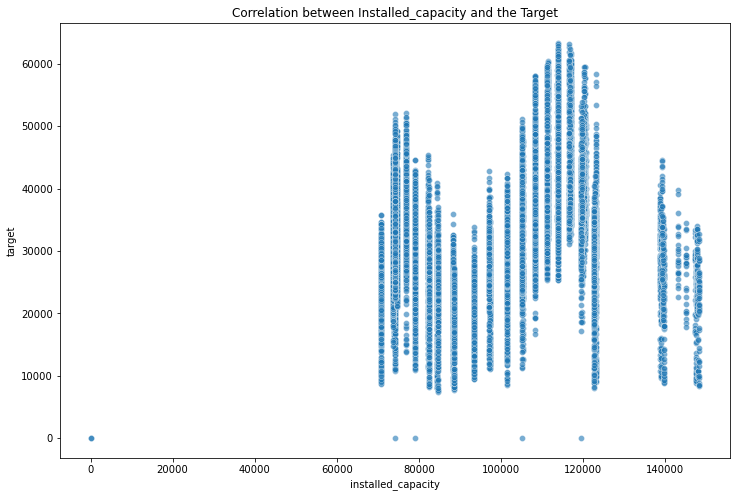

In [103]:
correlationPlot(consumptionOnly_hourly, 'installed_capacity', 'target')

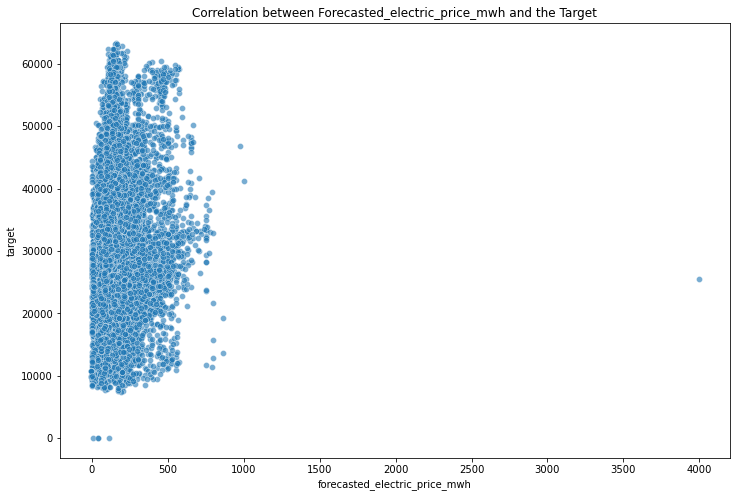

In [105]:
correlationPlot(consumptionOnly_hourly,'forecasted_electric_price_mwh', 'target')

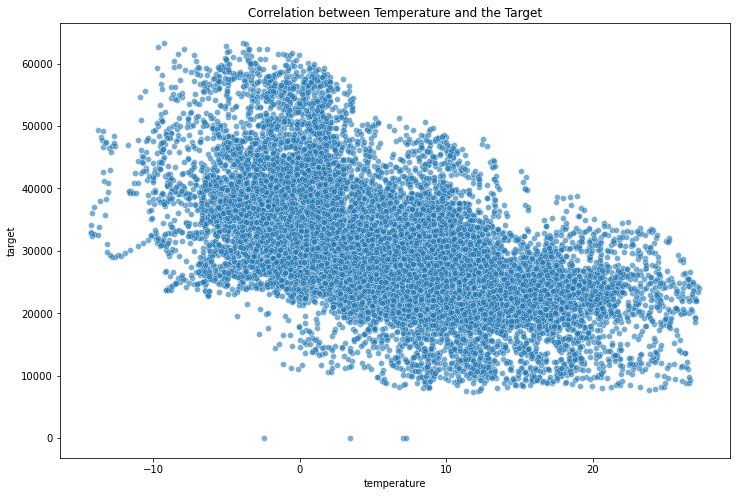

In [106]:
correlationPlot(consumptionOnly_hourly, 'temperature', 'target')

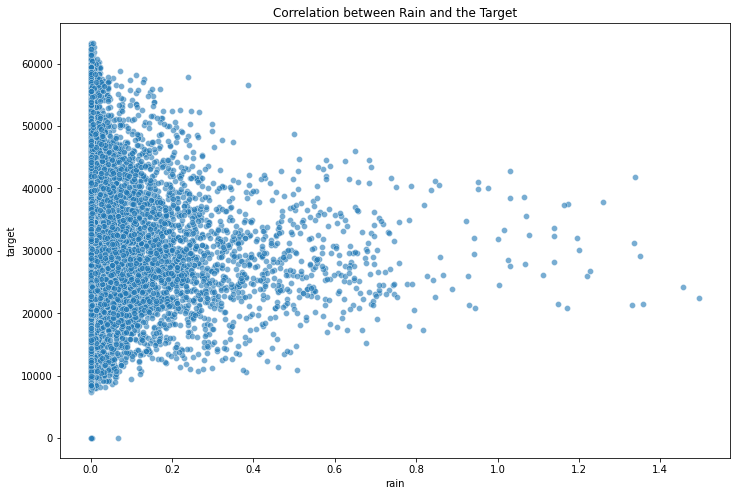

In [107]:
correlationPlot(consumptionOnly_hourly, 'rain', 'target')

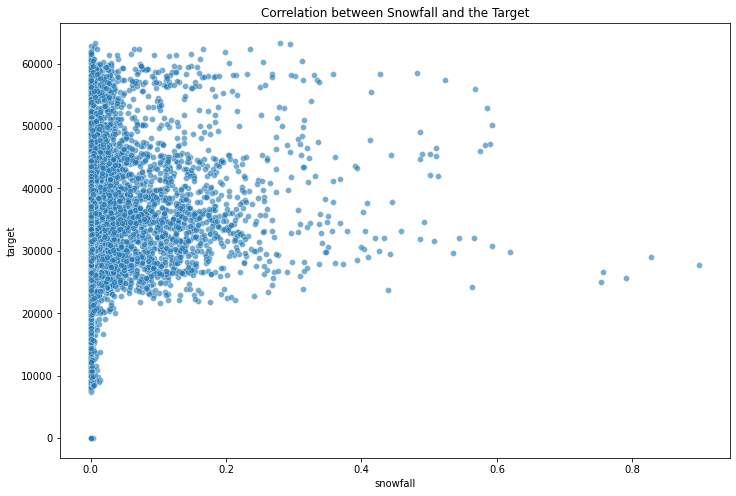

In [108]:
correlationPlot(consumptionOnly_hourly, 'snowfall', 'target')

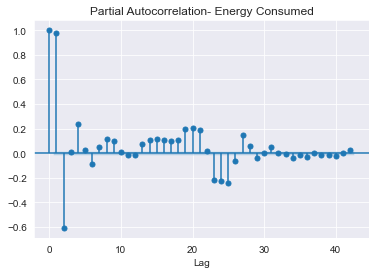

In [90]:
plot_pacf(consumptionOnly_hourly['target'],)
plt.xlabel("Lag")
plt.title("Partial Autocorrelation- Energy Consumed")
plt.savefig("partial_auto_econsumed.png")
plt.show()

In [92]:
lags = [1,2,24,168]
for lag in lags:
    createLag(consumptionOnly_hourly, lag)

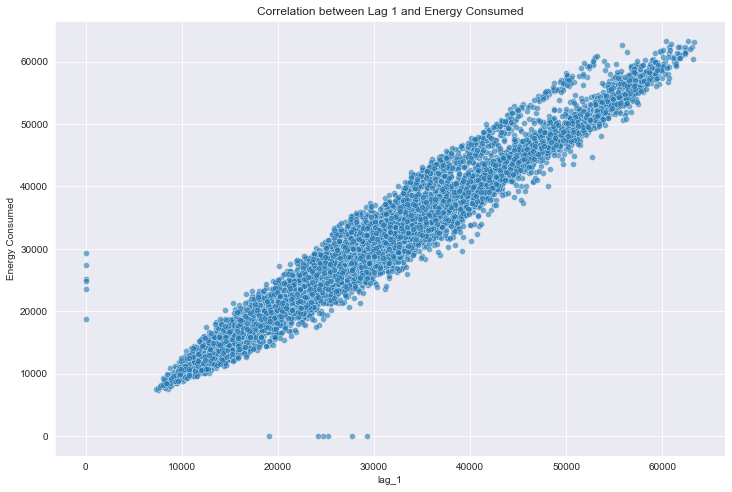

In [93]:
correlationPlot(consumptionOnly_hourly, 'lag_1', 'target')
plt.title("Correlation between Lag 1 and Energy Consumed")
plt.ylabel("Energy Consumed")
plt.savefig("lag1_vs_econsumed.png")
plt.show()

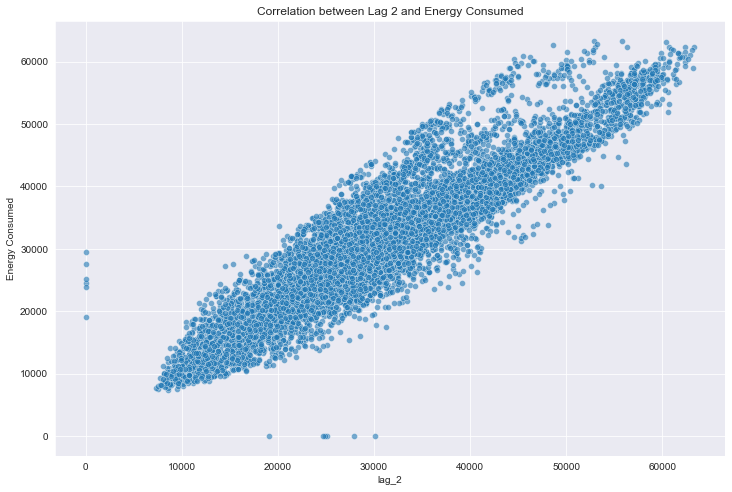

In [106]:
correlationPlot(consumptionOnly_hourly, 'lag_2', 'target')
plt.title("Correlation between Lag 2 and Energy Consumed")
plt.ylabel("Energy Consumed")
plt.savefig("lag2_vs_econsumed.png")
plt.show()

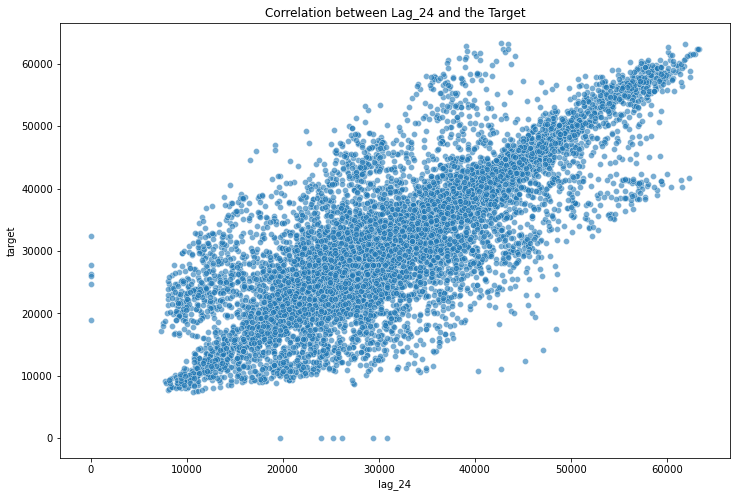

In [115]:
correlationPlot(consumptionOnly_hourly, 'lag_24', 'target')

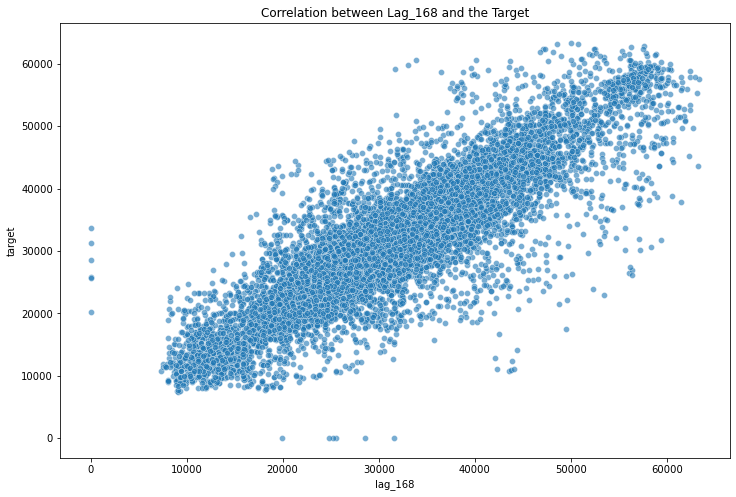

In [116]:
correlationPlot(consumptionOnly_hourly, 'lag_168', 'target')

In [ ]:
# Extracting Datetime Features

In [98]:
dtf = DatetimeFeatures(
    variables = None,
    features_to_extract = ['hour','month', 'year', 'day_of_week', 'weekend'],
    drop_original = False)

consumptionOnly_hourly = dtf.fit_transform(consumptionOnly_hourly.reset_index())
consumptionOnly_hourly.set_index('datetime', inplace = True)

def cyclicalFeature(datetime):
    consumptionOnly_hourly[str(datetime)+"_cosine"] = np.cos(consumptionOnly_hourly[datetime] /
                              consumptionOnly_hourly[datetime].max() * 2 * np.pi)
    consumptionOnly_hourly[str(datetime)+"_sin"] = np.sin(consumptionOnly_hourly[datetime] /
                              consumptionOnly_hourly[datetime].max() * 2 * np.pi)
periods = ['datetime_hour', 'datetime_month', 'datetime_day_of_week']
for datetime in periods:
    cyclicalFeature(datetime)
def plotDatetimeAverage(datetime):
    consumptionOnly_hourly.groupby(datetime)['target'].mean().plot(figsize = (18,10))
    plt.title('Average Energy Consumed in ' + "Per " + str(datetime)[9:])

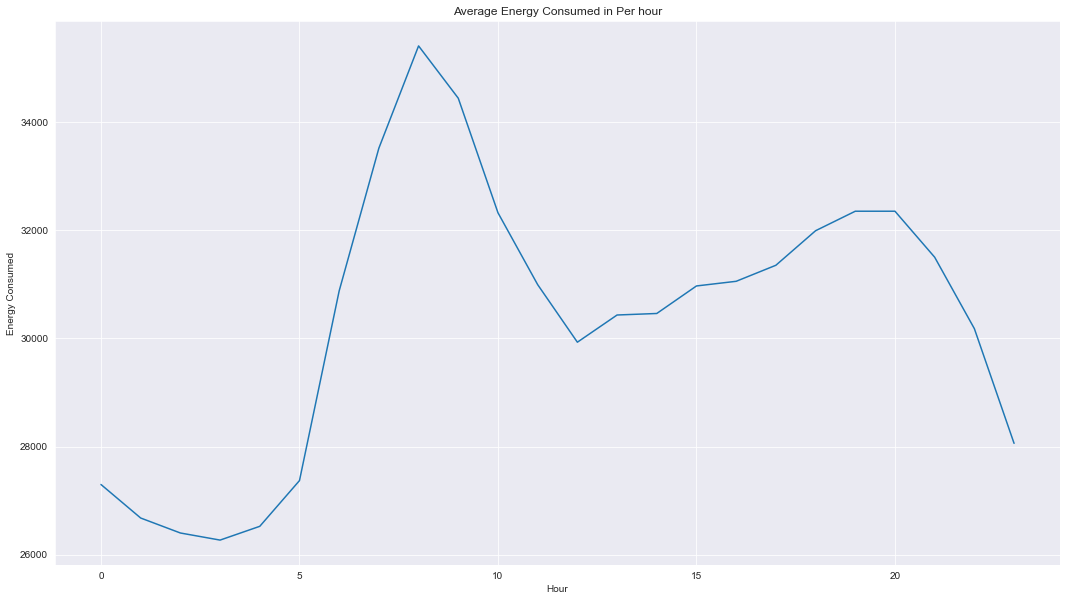

In [100]:
plotDatetimeAverage('datetime_hour')
plt.xlabel("Hour")
plt.ylabel("Energy Consumed")
plt.savefig("energy_consumed_perhour.png")
plt.show()

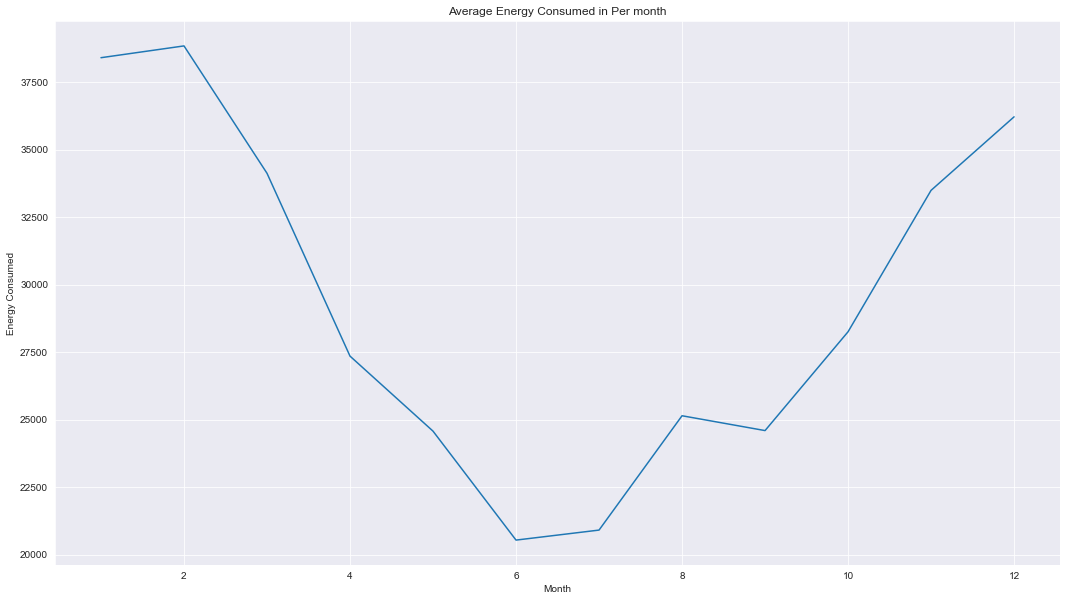

In [104]:
plotDatetimeAverage('datetime_month')
plt.xlabel("Month")
plt.ylabel("Energy Consumed")
plt.savefig("energy_consumed_permonth.png")
plt.show()

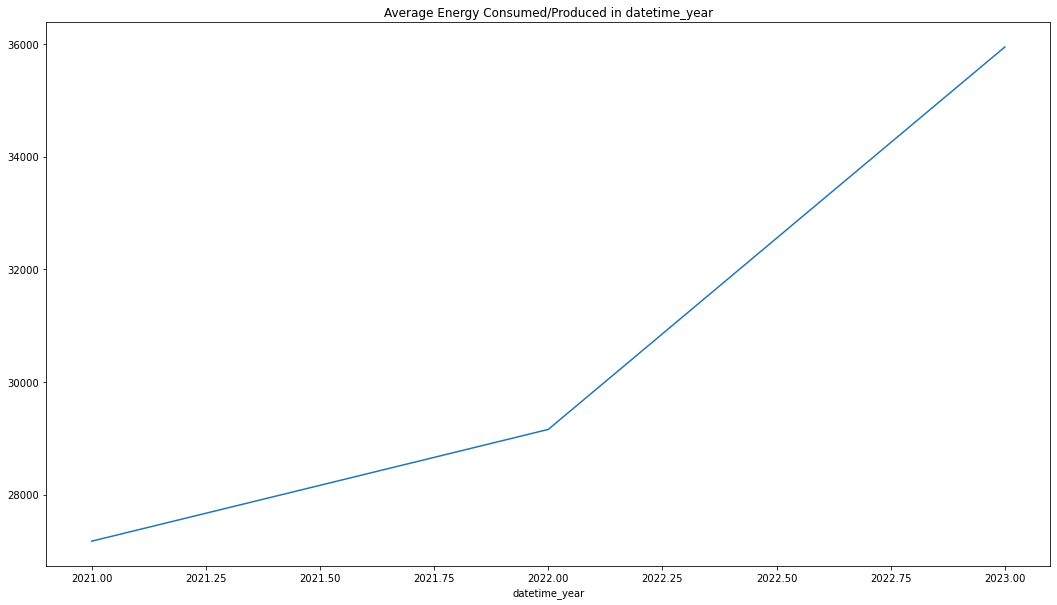

In [122]:
plotDatetimeAverage('datetime_year')

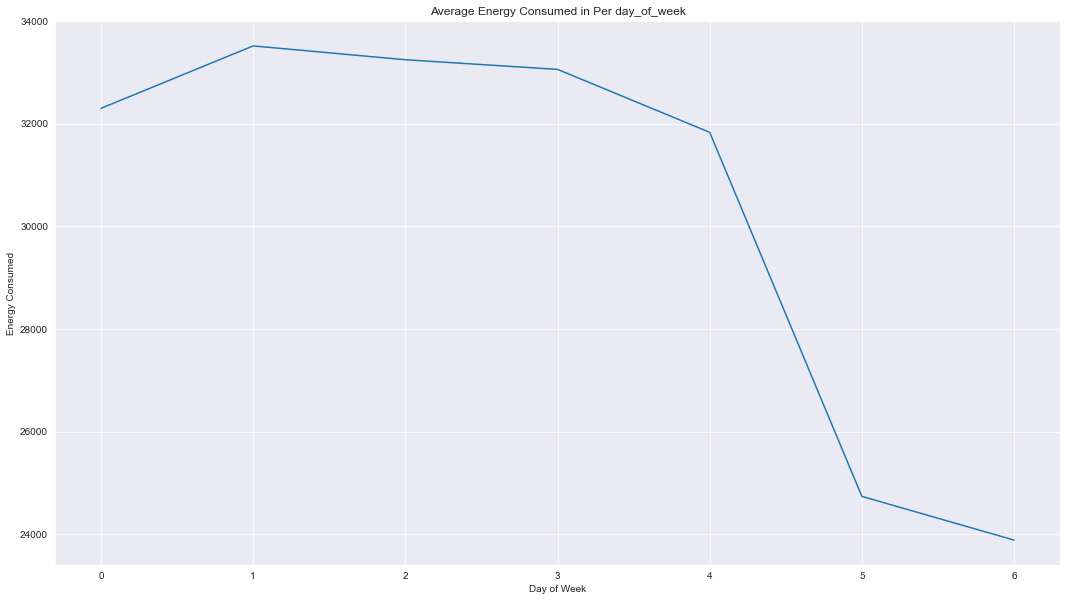

In [105]:
plotDatetimeAverage('datetime_day_of_week')
plt.xlabel("Day of Week")
plt.ylabel("Energy Consumed")
plt.savefig("energy_consumed_perday_of_week.png")
plt.show()

In [125]:
consumptionOnly_hourly.to_csv('consumptionOnly_features.csv', index=True)

In [119]:
consumptionOnly_hourly.columns

Index(['installed_capacity', 'eic_count',
       'forecasted_lowest_gas_price_per_mwh',
       'forecasted_highest_gas_price_per_mwh', 'forecasted_electric_price_mwh',
       'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'latitude', 'longitude', 'target', 'total_radiation',
       'solar_radiation_ratio', 'solar_radiation_product', 'lag_1', 'lag_2',
       'lag_24', 'lag_168', 'datetime_hour', 'datetime_month', 'datetime_year',
       'datetime_day_of_week', 'datetime_weekend', 'datetime_hour_cosine',
       'datetime_hour_sin', 'datetime_month_cosine', 'datetime_month_sin',
       'datetime_day_of_week_cosine', 'datetime_day_of_week_sin'],
      dtype='object')

In [201]:
df[['installed_capacity','eic_count', 'forecasted_lowest_gas_price_per_mwh', 'forecasted_highest_gas_price_per_mwh', 'forecasted_electric_price_mwh', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure',
       'cloudcover_total', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'windspeed_10m', 'winddirection_10m',
       'shortwave_radiation', 'direct_solar_radiation', 'diffuse_radiation',
       'latitude', 'longitude', 'target']]

installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00              952.89        108   
2021-09-01 00:00:00              384.30         39   
2021-09-01 00:00:00              384.30         39   
2021-09-01 00:00:00             1852.90         48   
2021-09-01 00:00:00             1852.90         48   
...                                 ...        ...   
2023-05-29 23:00:00              530.60         10   
2023-05-29 23:00:00              530.60         10   
2023-05-29 23:00:00             4776.10         95   
2023-05-29 23:00:00              540.00         17   
2023-05-29 23:00:00             2188.20         55   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
...                                                  ...   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
...                                                   ...   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   

                     forecasted_electric_price_mwh  temperature   dewpoint  \
datetime                                                                     
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
2021-09-01 00:00:00                          96.99    13.308929  10.987500   
...                                            ...          ...        ...   
2023-05-29 23:00:00                          -1.29     9.902679   3.561607   
2023-05-29 23:00:00                          -1.29     9.902679   3.561607   
2023-05-29 23:00:00                          -1.29     9.902679   3.561607   
2023-05-29 23:00:00                          -1.29     9.902679   3.561607   
2023-05-29 23:00:00                          -1.29     9.902679   3.561607   

                         rain  snowfall  surface_pressure  ...  \
datetime                                                   ...   
2021-09-01 00:00:00  0.013393   0.00000       1009.517857  ...   
2021-09-01 00:00:00  0.013393   0.00000       1009.517857  ...   
2021-09-01 00:00:00  0.013393   0.00000       1009.517857  ...   
2021-09-01 00:00:00  0.013393   0.00000       1009.517857  ...   
2021-09-01 00:00:00  0.013393   0.00000       1009.517857  ...   
...                       ...       ...               ...  ...   
2023-05-29 23:00:00  0.000000   0.00375       1013.811607  ...   
2023-05-29 23:00:00  0.000000   0.00375       1013.811607  ...   
2023-05-29 23:00:00  0.000000   0.00375       1013.811607  ...   
20

<AxesSubplot:xlabel='datetime'>

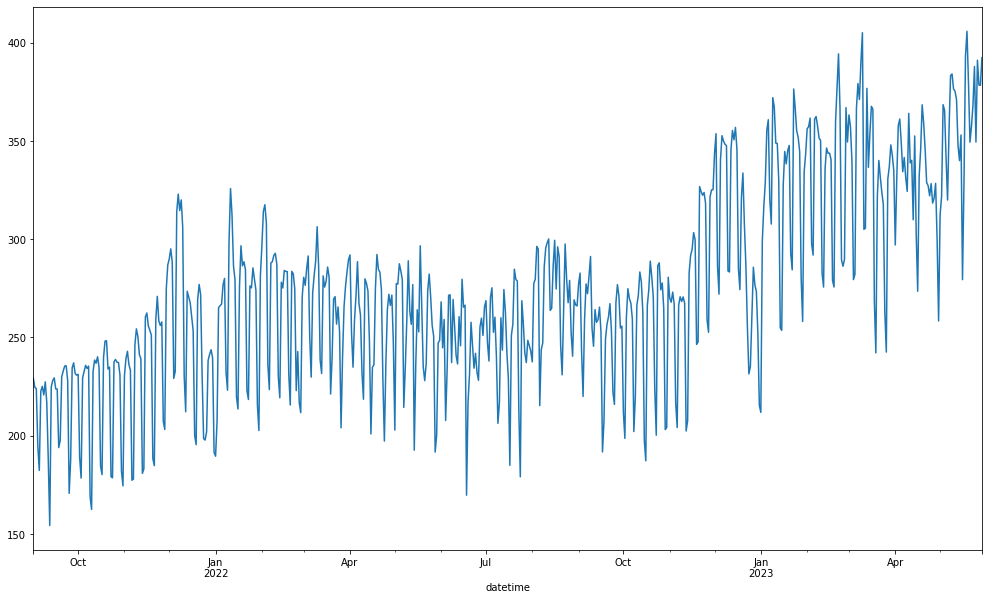

In [18]:
df.resample('D').mean()['target'].plot(figsize = (17,10))

In [5]:
trainCols = ['target',  'datetime']
train = pd.read_csv('train.csv', usecols = trainCols, parse_dates = ['datetime']) 
train.set_index('datetime', inplace = True)

In [7]:
daily_consumption = train.resample('D').mean()
daily_consumption

target
datetime              
2021-09-01  229.315351
2021-09-02  224.627911
2021-09-03  223.982432
2021-09-04  194.786869
2021-09-05  182.381657
...                ...
2023-05-27  378.433861
2023-05-28  378.323915
2023-05-29  392.325769
2023-05-30  392.034659
2023-05-31  410.291347

[638 rows x 1 columns]

In [12]:
daily_forecasted_gas_prices = pd.read_csv('gas_prices.csv', parse_dates = ['origin_date', 'forecast_date'])
newNameGas = {'lowest_price_per_mwh':'forecasted_lowest_gas_price_per_mwh',
              'highest_price_per_mwh': 'forecasted_highest_gas_price_per_mwh',
              'forecast_date': 'gas_forecast_date',
              'origin_date': 'gas_origin_date'}
daily_forecasted_gas_prices.rename(columns = newNameGas,inplace = True)
daily_forecasted_gas_prices

gas_forecast_date  forecasted_lowest_gas_price_per_mwh  \
0          2021-09-01                                45.23   
1          2021-09-02                                45.62   
2          2021-09-03                                45.85   
3          2021-09-04                                46.30   
4          2021-09-05                                46.30   
..                ...                                  ...   
632        2023-05-26                                29.10   
633        2023-05-27                                28.30   
634        2023-05-28                                28.10   
635        2023-05-29                                28.16   
636        2023-05-30                                29.00   

     forecasted_highest_gas_price_per_mwh gas_origin_date  data_block_id  
0                                   46.32      2021-08-31              1  
1                                   46.29      2021-09-01              2  
2                                   46.40      2021-09-02              3  
3                                   46.80      2021-09-03              4  
4                                   46.58      2021-09-04              5  
..                                    ...             ...            ...  
632                                 34.10      2023-05-25            633  
633                                 34.10      2023-05-26            634  
634                                 34.10      2023-05-27            635  
635                                 36.98      2023-05-28            636  
636                                 34.00      2023-05-29            637  

[637 rows x 5 columns]

In [13]:
electricity_prices = pd.read_csv('electricity_prices.csv', parse_dates = ['origin_date', 'forecast_date'])
newNameElectricity = {'euros_per_mwh': 'forecasted_electric_price_mwh',
                      'forecast_date': 'electric_forecast_datetime',
                      'origin_date': 'electric_origin_datetime'}
electricity_prices.rename(columns = newNameElectricity, inplace = True)
electricity_prices.set_index('electric_origin_datetime', inplace = True)
daily_forecasted_electric_prices = electricity_prices.resample('D').mean()
daily_forecasted_electric_prices.head()

forecasted_electric_price_mwh  data_block_id
electric_origin_datetime                                              
2021-08-31                                   110.467083            1.0
2021-09-01                                   112.631250            2.0
2021-09-02                                   107.429583            3.0
2021-09-03                                   106.112917            4.0
2021-09-04                                    99.045417            5.0

In [9]:
electricity_prices = pd.read_csv('electricity_prices.csv', parse_dates = ['origin_date', 'forecast_date'])
newNameElectricity = {'euros_per_mwh': 'forecasted_electric_price_mwh',
                      'forecast_date': 'electric_forecast_datetime',
                      'origin_date': 'electric_origin_datetime'}
electricity_prices.rename(columns = newNameElectricity, inplace = True)
electricity_prices['electric_forecast_date'] = pd.to_datetime(electricity_prices['electric_forecast_datetime'].dt.date)
electricity_prices['electric_origin_date'] = pd.to_datetime(electricity_prices['electric_origin_datetime'].dt.date)

In [10]:
electricity_prices.head()

electric_forecast_datetime  forecasted_electric_price_mwh  \
0        2021-09-01 00:00:00                          92.51   
1        2021-09-01 01:00:00                          88.90   
2        2021-09-01 02:00:00                          87.35   
3        2021-09-01 03:00:00                          86.88   
4        2021-09-01 04:00:00                          88.43   

  electric_origin_datetime  data_block_id electric_forecast_date  \
0      2021-08-31 00:00:00              1             2021-09-01   
1      2021-08-31 01:00:00              1             2021-09-01   
2      2021-08-31 02:00:00              1             2021-09-01   
3      2021-08-31 03:00:00              1             2021-09-01   
4      2021-08-31 04:00:00              1             2021-09-01   

  electric_origin_date  
0           2021-08-31  
1           2021-08-31  
2           2021-08-31  
3           2021-08-31  
4           2021-08-31

In [14]:
historical_weather = pd.read_csv('historical_weather.csv', parse_dates = ['datetime'])
weatherDatetime = {'datetime': 'weather_datetime'}
historical_weather.rename(columns = weatherDatetime, inplace = True)
historical_weather.set_index('weather_datetime', inplace = True)
daily_weather_condition = historical_weather.resample('D').mean()
daily_weather_condition

temperature  dewpoint      rain  snowfall  surface_pressure  \
weather_datetime                                                                
2021-09-01          13.393229  8.656734  0.012686  0.000000       1008.299107   
2021-09-02          12.085826  6.614695  0.049442  0.000000       1009.637612   
2021-09-03          11.764286  6.460417  0.086942  0.000000       1003.580915   
2021-09-04          10.214583  5.164211  0.078497  0.000000       1011.287909   
2021-09-05           9.762240  3.339323  0.002939  0.000000       1019.681138   
...                       ...       ...       ...       ...               ...   
2023-05-26          11.904055  3.823810  0.020089  0.000417       1013.385268   
2023-05-27          10.852232  1.815179  0.007440  0.002448       1019.855841   
2023-05-28          12.489100  4.215997  0.000037  0.004427       1015.221317   
2023-05-29          12.095871  5.518564  0.010193  0.003698       1013.227009   
2023-05-30          10.076623  4.150325  0.019481  0.000284       1014.261039   

                  cloudcover_total  cloudcover_low  cloudcover_mid  \
weather_datetime                                                     
2021-09-01               38.331845       24.844494       20.702753   
2021-09-02               53.978423       30.040179       44.061756   
2021-09-03               49.371652       30.211310       39.008557   
2021-09-04               32.096354       18.350446       25.052083   
2021-09-05               63.609003       29.165923       42.150298   
...                            ...             ...             ...   
2023-05-26               20.912574        8.183780       17.867188   
2023-05-27               15.173363        5.373884       17.003720   
2023-05-28               16.064732        6.597842       14.758185   
2023-05-29               43.140625       13.825521       38.373512   
2023-05-30               39.996753        3.718344       53.003247   

                  cloudcover_high  windspeed_10m  winddirection_10m  \
weather_datetime                                                      
2021-09-01              12.554315       6.407242         327.347842   
2021-09-02              15.465402       6.373832         309.489583   
2021-09-03               3.451637       7.450097         316.503348   
2021-09-04               1.934152       5.336888         326.491071   
2021-09-05              62.001116       4.005808         299.940476   
...                           ...            ...                ...   
2023-05-26              12.822545       5.355128         281.107515   
2023-05-27               4.259673       4.758629         289.567336   
2023-05-28               8.821429       5.206019         214.126488   
2023-05-29              31.211682       3.325965         270.834449   
2023-05-30              16.181818       3.127773         260.558442   

                  shortwave_radiation  direct_solar_radiation  \
weather_datetime                                                
2021-09-01                 167.003720              110.601935   
2021-09-02                 151.454613               93.398810   
2021-09-03                 152.469866               99.556920   
2021-09-04                 171.817708              116.502232   
2021-09-05                 143.152158               68.785714   
...                               ...                     ...   
2023-05-26                 267.898810              196.101190   
2023-05-27                 294.635789              221.167411   
2023-05-28                 300.810268              235.020461   
2023-05-29                 266.370164              180.800223   
2023-05-30                 152.443994               92.942370   

                  diffuse_radiation  latitude  longitude  data_block_id  
weather_datetime                                                         
2021-09-01                56.401786     58.65      24.95       1.541667  
2021-09-02                58.055804     58.65      24.95     

In [15]:
df = importData()

Loading datasets...
datasets loaded
resampling historical weather...
historical weather dataset resampled
merging datasets...
gas and electricty
forecasted energy prices merged
energy and weather
historical weather and energy prices merged
train and other features


C:\Users\Dell\AppData\Local\Temp/ipykernel_2512/3056260545.py:49: FutureWarning: Passing 'suffixes' which cause duplicate columns {'data_block_id_y'} in the result is deprecated and will raise a MergeError in a future version.
  hourlyEnergyConsumptionWeather = pd.merge(train, weatherEnergyPrices, left_on = 'datetime', right_on = 'weather_datetime', how = 'inner')


all features merging
all datasets merged...
features selected...


<AxesSubplot:xlabel='datetime'>

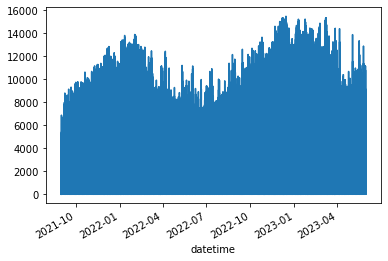

In [17]:
df['target'].plot()

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

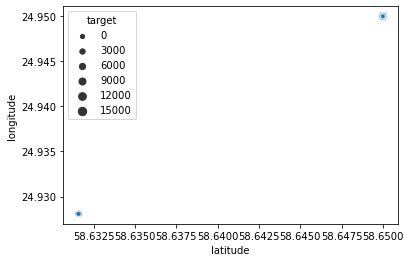

In [38]:
sns.scatterplot(x= 'latitude',y= 'longitude', size = 'target', data = df)

In [25]:
df

county  is_business  product_type  is_consumption  \
datetime                                                                 
2021-09-01 00:00:00       0            0             1               0   
2021-09-01 00:00:00      11            0             1               1   
2021-09-01 00:00:00      11            0             1               0   
2021-09-01 00:00:00      10            1             3               1   
2021-09-01 00:00:00      10            1             3               0   
...                     ...          ...           ...             ...   
2023-05-29 23:00:00       5            1             0               1   
2023-05-29 23:00:00       5            1             0               0   
2023-05-29 23:00:00      14            1             3               0   
2023-05-29 23:00:00       6            1             3               0   
2023-05-29 23:00:00      15            1             3               1   

                     installed_capacity  eic_count  \
datetime                                             
2021-09-01 00:00:00              952.89        108   
2021-09-01 00:00:00              384.30         39   
2021-09-01 00:00:00              384.30         39   
2021-09-01 00:00:00             1852.90         48   
2021-09-01 00:00:00             1852.90         48   
...                                 ...        ...   
2023-05-29 23:00:00              530.60         10   
2023-05-29 23:00:00              530.60         10   
2023-05-29 23:00:00             4776.10         95   
2023-05-29 23:00:00              540.00         17   
2023-05-29 23:00:00             2188.20         55   

                     forecasted_lowest_gas_price_per_mwh  \
datetime                                                   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
2021-09-01 00:00:00                                45.62   
...                                                  ...   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   
2023-05-29 23:00:00                                29.00   

                     forecasted_highest_gas_price_per_mwh  \
datetime                                                    
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
2021-09-01 00:00:00                                 46.29   
...                                                   ...   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   
2023-05-29 23:00:00                                 34.00   

                     forecasted_electric_price_mwh  temperature  ...  \
datetime                                                         ...   
2021-09-01 00:00:00                          96.99    13.308929  ...   
2021-09-01 00:00:00                          96.99    13.308929  ...   
2021-09-01 00:00:00                          96.99    13.308929  ...   
2021-09-01 00:00:00                          96.99    13.308929  ...   
2021-09-01 00:00:00                          96.99    13.308929  ...   
...                                            ...          ...  ...   
2023-05-29 23:00:00                          -1.29     9.902679  ...   
2023-05-29 23:00:00                          -1.29     9.902679  ...   
2023-05-29 23:00:00                          -1.29     9.902

In [11]:
df = df.fillna(method = 'ffill')

In [ ]:
df['target_lag1'] = df['target'].shift(1, freq = 'H')

In [ ]:
plt.figure(figsize = (20,17))
df['target'].plot(alpha = 0.8)
plt.show()

In [ ]:
plt.figure(figsize = (20,17))
df['temperature'].plot(kind = 'line')
plt.show()

In [ ]:
trainWeather = pd.merge(train, hourlyHistoricalWeather, left_on= ['datetime'], right_on= ['weather_datetime'], how = 'inner')
trainWeather

In [ ]:
trainWeather['date'] = pd.to_datetime(trainWeather['datetime'].dt.date)
trainWeather.info()

In [ ]:
client['date'] = pd.to_datetime(client['date'])

In [ ]:
trainWeatherClient = pd.merge(trainWeather, client, on = ['product_type', 'county', 'is_business', 'date'], how = 'inner')
trainWeatherClient.head()

In [ ]:
trainWeatherClient.columns

In [ ]:
client.groupby(['product_type', 'county', 'is_business', 'date']).count()

In [ ]:
trainWeather.isna().sum()

In [ ]:
average_energy_consumed = train.groupby(['datetime', 'is_business'])['target'].mean().reset_index()
average_energy_consumed.rename(columns = {'target': 'average_energy_consumed_by_entity'}, inplace = True)
average_energy_consumed

In [ ]:
merged = pd.merge(train, average_energy_consumed, on = ['datetime', 'is_business'], how= 'left')
merged_business = merged[['datetime', 'is_business','average_energy_consumed_by_entity', 'target']]
merged_business.set_index('datetime', inplace = True)
merged_business.resample('H').mean()

In [ ]:
average_energy_consumed_in_county = train.groupby(['datetime', 'county'])['target'].mean().reset_index()
average_energy_consumed_in_county

In [ ]:
train.groupby(['datetime', 'county', 'is_business', 'is_consumption'])['target'].mean().reset_index()

In [ ]:
hourlyEnergyConsumption

In [ ]:
data = importData()

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [ ]:
data = data.fillna(method = 'ffill')

In [ ]:
data.isna().sum()

In [ ]:
data.head()

In [ ]:
data['product_type'].value_counts()

In [ ]:
sns.set_theme(style='darkgrid')
plt.figure(figsize = (25,10))
data['target'].plot()
plt.show()

In [ ]:
sns.set_theme(style='darkgrid')
plt.figure(figsize = (25,10))
data['target'].plot(kind = 'hist', bins = 150)
plt.show()

## Exploring the datasets

In [ ]:
# Converting forecast and original date of gas prices
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices['origin_date'] = pd.to_datetime(gas_prices['origin_date'])

In [ ]:
# MErging gas and electricity prices
energy_prices = pd.merge(gas_prices, electricity_prices, on = ['forecast_date', 'data_block_id', 'origin_date'])

In [ ]:
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])

In [ ]:
electricity_prices['origin_date'] = pd.to_datetime(electricity_prices['origin_date'])

In [ ]:
# Merging historical weather with energy prices
energyHistoricalWeather = pd.merge(energy_prices, historical_weather, left_on = ['origin_datetime', 'data_block_id'], right_on = ['datetime', 'data_block_id'], how = 'inner')


In [ ]:
energyHistoricalWeather.head(3)

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
train.info()

In [ ]:
trainEnergyHistoricalWeather = pd.merge(client, train, left_on = ['origin_datetime', 'data_block_id'], right_on = ['datetime', 'data_block_id'], how = 'inner')

In [ ]:
energyHistoricalWeather.head(2)

In [ ]:
client.head(2)

### The train dataset

In [ ]:
check_dataframe(train)

In [ ]:
# Converting the datetime variable to datetime datatype
train['datetime'] = pd.to_datetime(train['datetime'], format= '%Y-%m-%d %H:%M:%S')

In [ ]:
# Dropping na in the target variable since it is a minute fraction of the size of the dataset

train.dropna(inplace = True)

In [ ]:
train.head()

In [ ]:
train.head()

In [ ]:
temp = train[['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime', 'data_block_id']]
temp.datetime

In [ ]:
temp.set_index('datetime', inplace = True)

In [ ]:
temp.head()

In [ ]:
catSummary = lambda x: x.mode().iloc[0]

In [ ]:
temp.columns.to_list()

In [ ]:
downsampling_rules = {
    'target': 'mean',             # Sum numerical values
    'county': lambda x: x.mode().iloc[0],            # Take the mean of numerical values
    'is_business': lambda x: x.mode().iloc[0],
    'product_type': lambda x: x.mode().iloc[0],
    'is_consumption': lambda x: x.mode().iloc[0],
    'data_block_id': lambda x: x.mode().iloc[0]# Select the most frequent category
}

In [ ]:
temp.head()

In [ ]:
hourlyConsumption = temp.resample('H').apply(downsampling_rules)

In [ ]:
dailyConsumption = temp.resample('D').apply(downsampling_rules)

In [ ]:
columns = hourlyConsumption.columns.to_list()
columns.remove('target')
print(columns)

In [ ]:
hourlyConsumption.reset_index(inplace = True)

In [ ]:
hourlyConsumption.isna().sum()

In [ ]:
hourlyConsumtion.groupby(['county', 'is_business', 'product_type', 'is_consumption',
       'data_block_id', 'datetime']).count()

In [ ]:
temp.index

In [ ]:
train.groupby(['county', 'is_business','is_consumption', 'product_type', 'datetime', 'data_block_id']).count()

In [ ]:
merged = pd.merge(train, client, on = ['county', 'is_business', 'product_type', 'date', 'data_block_id'])

In [ ]:
client.columns

In [ ]:
client.info()

In [ ]:
gas_prices.head()

In [ ]:
electricity_prices.head()

In [ ]:
client.head()

In [ ]:
forecast_weather.head()

In [ ]:
historical_weather.head()

In [ ]:
# Inspecting if na was removed from target
train.isna().sum()

#### Checking the shape of the train dataset after removing the NA in the target variable?


In [ ]:
train.shape

In [ ]:
## Duration of datetime of the dataset 
min(train['datetime']), max(train['datetime'])

In [ ]:
train.data_block_id.value_counts()

#### What is the distribution of the target variable?

In [ ]:
## Using the Square Root rule to select number of bins
bins1 = int(train.shape[0])**0.5

## Using sturgy's Rule
bins2 = 1 + math.log(train.shape[0], 8)

## Manual selection 
bins = 200
plt.figure(figsize = (15,10))
sns.histplot(train['target'], bins = bins).set(xlabel= 'Energy Produced/Consumed', title = 'Distribution of Energy Produced or Consumed')
plt.ticklabel_format(style= 'plain', axis = 'both')
plt.show()

### Data is heavily skewed to the right

In [ ]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(train.describe())

In [ ]:
### Creating a boxplot to visualize the skewness
plt.figure(figsize = (4, 7))
sns.boxplot(train['target']).set(title = 'Boxplot Distribution of the Energy Consumed/Production', ylabel = 'Energy Produced/Consumed')
plt.show()

In [ ]:
train.head()

In [ ]:
## Checking for trend of the target
## Creating a lineplot

In [ ]:
plt.figure(figsize = (15, 7))
sns.lineplot(x = 'datetime', y = 'target', data = train).set(xlabel = 'Datetime', ylabel = 'Energy Produced/Consumed', title = 'Energy Produced/Consumed By Datetime')
plt.show()

There is a seasonal pattern along the datetime variable. Energy Consumption is high at about the end of the year through first half of the year, then drops in the second half of the year.

#### Extracting datetime features for further datetime analysis

In [ ]:
def extractDateFeatures(dataframe, datetimeFeatures):
    for datetime in datetimeFeatures:
        if datetime == 'Year':
            dataframe[datetime] = dataframe['datetime'].dt.year
        elif datetime == 'Month':
            dataframe[datetime] = dataframe['datetime'].dt.month
        elif datetime == 'Week':
            dataframe[datetime] = dataframe['datetime'].dt.week
        elif datetime == 'DayofWeek':
            dataframe[datetime] = dataframe['datetime'].dt.dayofweek
        elif datetime == 'Day':
            dataframe[datetime] = dataframe['datetime'].dt.day
        elif datetime == 'Hour':
            dataframe[datetime] = dataframe['datetime'].dt.hour


In [ ]:
datetimeFeatures = ['Year', 'Month', 'Week', 'DayofWeek', 'Day', 'Hour']

In [ ]:
extractDateFeatures(train, datetimeFeatures)

In [ ]:
train.head()

In [ ]:
def plotDatetime(dataframe, datetime, target, kind, hueVar=None):
    if hueVar is None:
        plt.figure(figsize=(10, 6))
        dataframe.groupby(datetime)[target].mean().plot(kind=kind)
        plt.ylabel('Total Energy Produced/Consumed')
        plt.title('Total Energy Produced/Consumed Per ' + str(datetime))
        plt.show()
    else:
        plt.figure(figsize=(10, 6)) 
        categories = dataframe[hueVar].unique()
        for category in categories:
            temp = dataframe[dataframe[hueVar] == category]
            temp.groupby(datetime)[target].mean().plot(kind=kind, label=str(category))

        plt.ylabel('Total Energy Produced/Consumed')
        plt.title('Total Energy Produced/Consumed Per ' + str(datetime))
        plt.legend()
        plt.show()

In [ ]:
plotDatetime(train, 'Year','target', 'line')

The bar plot reveals an increase in energy production per year.

In [ ]:
plotDatetime(train,'Month', 'target', 'line')

The above Bar Plot shows that the Average Energy Consumption is relatively stable from January to May, and drops in June through October, which is Summer through to early Fall. The in November, the energy Consumed/Produced increases again.

In [ ]:
plotDatetime(train, 'Week','target', 'line')

Though on a granular level, the above bar chart coresponds to the bar chart of the monthly production/consumption of energy of prosumers. Energy production/consumption drops from week 23 through to week 46 (summer through early fall). The energy production/consumption picks back up from late Fall through to late Spring

In [ ]:
plotDatetime(train,'Day','target', 'line')

The average energy consumed/produced per day of month does not vary that much. They range from 250 to about 290.

In [ ]:
plotDatetime(train, 'DayofWeek', 'target', 'line')

The above bar chart show that the energy produced/consumed as relatively the same during the weekdays, however, energy produced/consumed drops at the weekend.

In [ ]:
plotDatetime(train, 'Hour','target', 'line')

The above bar chart indicates that the energy/consumed starts to rise early morning and it's at its peak during the afternoon. 

In [ ]:
train.head(1)

### Deeper Exploration of the Target (Energy Consumed/Produced) in the Conext of Whether the Observation is a Business, Which County, and Product Type.

In [ ]:
plt.figure(figsize = (4, 7))
sns.boxplot(x = train['target'], y = train['is_business']).set(title = 'Boxplot Distribution of the Energy Consumed/Production', ylabel = 'Energy Produced/Consumed')
plt.show()

In [ ]:
plt.figure(figsize = (7,7))
train.value_counts('is_business').plot(kind = 'bar')
plt.title('Total Number of Business (1) and Non-Business (0)')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))

plt.show()
plt.show()

There is a larger number of businesses in the dataset compared to non-business. Although, the difference is not too wide.

In [ ]:
plotDatetime(train, 'Year', 'target', 'line', 'is_business')

The above plot show that there is an overall increase in the average energy consumption/generation over the years. However, the average energy consumed by businesses is significantly higher than that of not business.

In [ ]:
plotDatetime(train, 'Month', 'target', 'line', 'is_business')

The above chart of average energy consumed by both businesses and non-business tend to drop in the middle of the year

In [ ]:
plotDatetime(train, 'Week', 'target', 'line', 'is_business')

The above chart of total energy produced/consumed by businesses and non-businesses vary. 
While the energy produced/consumed by business drops consistently from the earlier weeks of the year and flactuates in the middle of the year, the average energy of non-businesses steadily rise
from about 2nd week to about 20th Week, then drops untill about 45th week. 

In [ ]:
train.columns

In [ ]:
plotDatetime(train, 'DayofWeek', 'target', 'line', 'is_business')

The above chart indicates that the average energy production/consumption vary considerably between businesses and non-businesses. Average energy consumed/produced by businesses is relatively constant around 450Kwh and drops to about 350Kwh on Saturdays and Sundays. While average energy production/consumption remains relatively constant around 110 Kwh and rises to about 130 during the weekends.

In [ ]:
plotDatetime(train, 'Day', 'target', 'line', 'is_business')

The above chart shows that there is not much variation in the fluctuation of average energy consumption/production between businesses and non-businesses regarding. 

In [ ]:
plotDatetime(train, 'Hour', 'target', 'line', 'is_business')

The above chart indicates that the average energy produced/consumed is both high during the day. At about 6am, the average energy begin to rise and reach it peak around noon then steadily drops. At night, average energy produced/consumped is at its lowest.

In [ ]:
train.head(1)

In [ ]:
plt.figure(figsize = (7,8))
train['product_type'].value_counts().plot(kind = 'bar')
plt.xlabel('Product Type')
plt.title('Count of Different Product Types 0: Combined, 1: Fixed, 2: General Service, 3: Spot')
plt.show()

In [ ]:
train.columns

In [ ]:
plotDatetime(train, 'Year', 'target', 'line', 'product_type')

In [ ]:
plotDatetime(train, 'Month', 'target', 'line', 'product_type')

In [ ]:
plotDatetime(train, 'Week', 'target', 'line', 'product_type')

In [ ]:
plotDatetime(train, 'DayofWeek', 'target', 'line', 'product_type')

In [ ]:
plotDatetime(train, 'Day', 'target', 'line', 'product_type')

In [ ]:
plotDatetime(train, 'Hour', 'target', 'line', 'product_type')

In [ ]:
train.columns

In [ ]:
plt.figure(figsize = (7,8))
train['county'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Observatons by County')
plt.show()

In [ ]:
plotDatetime(train, 'Year', 'target', 'line', 'county')

In [ ]:
plotDatetime(train, 'Month', 'target', 'line', 'county')

In [ ]:
plotDatetime(train, 'Week', 'target', 'line', 'county')

In [ ]:
plotDatetime(train, 'DayofWeek', 'target', 'line', 'county')

In [ ]:
plotDatetime(train, 'Year', 'target', 'line', 'county')